# Import and set colors

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors
from gprofiler import gprofiler

import os 
#doublet detection
import scrublet as scr

#external modules
import scanpy.external as sce
#pretty plotting
import seaborn as sb


#R interface
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython


In [3]:
plt.rcParams['figure.figsize']=(4,3) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300, fontsize=16, color_map='plasma')
sc.logging.print_header()

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.21.2 scipy==1.8.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.4


In [4]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(DropletUtils)



In [5]:
#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Set project file paths

We set up the file paths to the respective directories.

In [6]:
file_path = '/Volumes/Seagate_Exp/Paper_sc_analysis/' 
#this is my file path please adapt it to your directory

In [7]:
matrix= file_path + 'rawdata/' 

In [8]:
data_dir = file_path + 'data_earlytp/' 

In [9]:
table_dir = file_path + 'tables_earlytp/'

In [10]:
sc.settings.figdir = file_path + 'figures_earlytp/'

In [11]:
import datetime

today = datetime.date.today().strftime('%y%m%d') #creates a YYMMDD string of today's date

# Reading in the data

In [12]:
# Set up data loading
#Explanation directory of one sample '/Volumes/Seagate_Exp/Single_cell_112020/Data/MUC13721_3dDMSO'
#Data files 
sample_strings = ['5dpi_Veh','5dpi_Inh', 'Intact',
                  '3dDMSO', '3dpiV', '3dpiV', '3dpiINH',
                 '3dpiINH', '3dDMSO', '5dpiVeh', 
                 '5dpiINH', '5dpiINH', '5dDMSO', '5dDMSO', '5dpiVeh', ]


sample_id_strings = ['21L008532', '21L008533', '21L008590','MUC13721', 'MUC13722', 'MUC13723', 'MUC13724', 'MUC13725',  'MUC13726', 'MUC13727', 'MUC13729', 'MUC13730',
                    'MUC13731', 'MUC13732', 'MUC13715']

file_base = matrix

data_file_end = '_matrix.mtx.gz'
barcode_file_end = '_barcodes.tsv.gz'
gene_file_end = '_features.tsv.gz'



In [13]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
sample_id = sample_id_strings.pop(0)
folder = file_base+sample_id+'_'+sample

#Load data
adata = sc.read_10x_mtx(folder, cache=True)

adata.obs['sample'] = [sample_id+'_'+sample]*adata.n_obs
adata.obs['sample_id'] = [sample_id]*adata.n_obs
adata.obs['sample_id_str'] = [sample_id+'_'+sample]*adata.n_obs

... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-21L008532_5dpi_Veh-matrix.h5ad


In [14]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    sample_id = sample_id_strings[i]
    folder = file_base+sample_id+'_'+sample
    
    #Load data
    adata_tmp = sc.read_10x_mtx(folder, cache=True)
    
    
    #Annotate data
    adata_tmp.obs['sample'] = [sample_id+'_'+sample]*adata_tmp.n_obs
    adata_tmp.obs['sample_id'] = [sample_id]*adata_tmp.n_obs
    adata_tmp.obs['sample_id_str'] = [sample_id+'_'+sample]*adata_tmp.n_obs
    
    # Concatenate to main adata object
    adata_tmp = adata_tmp[:,adata.var_names]
    adata = adata.concatenate(adata_tmp, batch_key='sample')
    adata.obs.drop(columns=['sample'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-21L008533_5dpi_Inh-matrix.h5ad
... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-21L008590_Intact-matrix.h5ad
... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-MUC13721_3dDMSO-matrix.h5ad
... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-MUC13722_3dpiV-matrix.h5ad
... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-MUC13723_3dpiV-matrix.h5ad
... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-MUC13724_3dpiINH-matrix.h5ad
... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-MUC13725_3dpiINH-matrix.h5ad
... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-MUC13726_3dDMSO-matrix.h5ad
... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-MUC13727_5dpiVeh-matrix.h5ad
... reading from cache 

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['CAACCTCGTAGCGTCC_1']
  warnings.warn(


... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-MUC13730_5dpiINH-matrix.h5ad


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['CTGCCTAAGACAGACC_1']
  warnings.warn(


... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-MUC13731_5dDMSO-matrix.h5ad


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['CATCGGGAGTGAACGC_1', 'CTAATGGAGGCTATCT_1', 'GTGCTTCCATCCCACT_1', 'TGGCCAGGTCTGATCA_1', 'TTGGAACGTGTTTGTG_1']
  warnings.warn(


... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-MUC13732_5dDMSO-matrix.h5ad


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['CACCAGGTCCTGCCAT_1', 'CAGCGACTCGCATGAT_1', 'CGGACACCAGCTATTG_1', 'CTTTGCGTCACGAAGG_1', 'GTCTCGTAGTGAAGAG_1']
  warnings.warn(


... reading from cache file cache/Volumes-Seagate_Exp-Paper_sc_analysis-rawdata-MUC13715_5dpiVeh-matrix.h5ad


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['AGCATACGTGATGTGG_1', 'ATAGACCGTTATTCTC_1', 'CCTCTGATCAAGGTAA_1', 'GCCAAATTCTGACCTC_1', 'GCTTCCAGTCGAACAG_1']
  warnings.warn(
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (_[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['AGCTTGACAAGCGTAG_1', 'ATCCGAAGTGTCTGAT_1', 'ATTGGTGAGAGTTGGC_1', 'CACCACTCATAAAGGT_1', 'CAGCTAAGTTAAGG

In [15]:
adata.obs_names_make_unique()

In [16]:
adata.var_names_make_unique()

In [17]:
# Annotate the data sets
print(adata.obs['sample_id_str'].value_counts())

21L008533_5dpi_Inh    10000
21L008532_5dpi_Veh    10000
MUC13715_5dpiVeh       8637
21L008590_Intact       7668
MUC13730_5dpiINH       6429
MUC13729_5dpiINH       6146
MUC13732_5dDMSO        5868
MUC13731_5dDMSO        5318
MUC13725_3dpiINH       4466
MUC13726_3dDMSO        3816
MUC13721_3dDMSO        3780
MUC13724_3dpiINH       3072
MUC13722_3dpiV         2959
MUC13723_3dpiV         2880
MUC13727_5dpiVeh       2794
Name: sample_id_str, dtype: int64


In [18]:
# Checking the total size of the data set
adata.shape

(83833, 27998)

# Split batches and QC cell bases 

In [19]:
sample_id_str2condition = {
 '21L008532_5dpi_Veh':'5dpi_V',
 '21L008533_5dpi_Inh':'5dpi_I',
 '21L008590_Intact':'Intact',
 'MUC13715_5dpiVeh':'5dpi_V',
 'MUC13721_3dDMSO':'Intact',
 'MUC13722_3dpiV':'3dpi_V',
 'MUC13723_3dpiV':'3dpi_V',
 'MUC13724_3dpiINH':'3dpi_I',
 'MUC13725_3dpiINH':'3dpi_I',
 'MUC13726_3dDMSO':'Intact',
 'MUC13727_5dpiVeh':'5dpi_V',
 'MUC13729_5dpiINH':'5dpi_I',
 'MUC13730_5dpiINH':'5dpi_I',
 'MUC13731_5dDMSO':'Intact',
 'MUC13732_5dDMSO':"Intact"
}

In [20]:
adata.obs['condition'] = adata.obs['sample_id_str'].map(sample_id_str2condition).astype('category')

In [21]:
#dooble check annotation
pd.crosstab(adata.obs['sample_id_str'],adata.obs['condition'])

condition           3dpi_I  3dpi_V  5dpi_I  5dpi_V  Intact
sample_id_str                                             
21L008532_5dpi_Veh       0       0       0   10000       0
21L008533_5dpi_Inh       0       0   10000       0       0
21L008590_Intact         0       0       0       0    7668
MUC13715_5dpiVeh         0       0       0    8637       0
MUC13721_3dDMSO          0       0       0       0    3780
MUC13722_3dpiV           0    2959       0       0       0
MUC13723_3dpiV           0    2880       0       0       0
MUC13724_3dpiINH      3072       0       0       0       0
MUC13725_3dpiINH      4466       0       0       0       0
MUC13726_3dDMSO          0       0       0       0    3816
MUC13727_5dpiVeh         0       0       0    2794       0
MUC13729_5dpiINH         0       0    6146       0       0
MUC13730_5dpiINH         0       0    6429       0       0
MUC13731_5dDMSO          0       0       0       0    5318
MUC13732_5dDMSO          0       0       0       0    5868

In [22]:
adata_1 = adata[np.in1d(adata.obs['sample_id_str'],['MUC13721_3dDMSO','MUC13722_3dpiV', 'MUC13723_3dpiV', 'MUC13724_3dpiINH', 'MUC13725_3dpiINH'])].copy()
adata_2 = adata[np.in1d(adata.obs['sample_id_str'],['MUC13726_3dDMSO', 'MUC13727_5dpiVeh', 'MUC13729_5dpiINH', 'MUC13730_5dpiINH', 'MUC13731_5dDMSO', 'MUC13732_5dDMSO'])].copy()
adata_3 = adata[np.in1d(adata.obs['sample_id_str'],['MUC13715_5dpiVeh'])].copy()
adata_4 = adata[np.in1d(adata.obs['sample_id_str'],['21L008590_Intact'])].copy()
adata_5 = adata[np.in1d(adata.obs['sample_id_str'],['21L008532_5dpi_Veh', '21L008533_5dpi_Inh',])].copy()

In [23]:
adata.obs['batch'] = 5
batch_3_cells = adata[adata.obs['sample_id_str'].isin(['MUC13721_3dDMSO','MUC13722_3dpiV', 'MUC13723_3dpiV', 'MUC13724_3dpiINH', 'MUC13725_3dpiINH'])].obs_names
adata.obs.loc[batch_3_cells,'batch'] = 1
batch_5a_cells = adata[adata.obs['sample_id_str'].isin(['MUC13726_3dDMSO', 'MUC13727_5dpiVeh', 'MUC13729_5dpiINH', 'MUC13730_5dpiINH', 'MUC13731_5dDMSO', 'MUC13732_5dDMSO'])].obs_names
adata.obs.loc[batch_5a_cells,'batch'] = 2
batch_5_cells = adata[adata.obs['sample_id_str'].isin(['MUC13715_5dpiVeh'])].obs_names
adata.obs.loc[batch_5_cells,'batch'] = 3
batch_28_cells = adata[adata.obs['sample_id_str'].isin([ '21L008590_Intact'])].obs_names
adata.obs.loc[batch_28_cells,'batch'] = 4
batch_5c_cells = adata[adata.obs['sample_id_str'].isin(['21L008532_5dpi_Veh', '21L008533_5dpi_Inh'])].obs_names
adata.obs.loc[batch_5c_cells,'batch'] = 5
#adata_main_correct.obs[['batch','sample']]
adata.obs['batch'] = adata.obs['batch'].astype('category')

In [24]:
#dooble check annotation
pd.crosstab(adata.obs['sample_id_str'],adata.obs['batch'])

batch                  1     2     3     4      5
sample_id_str                                    
21L008532_5dpi_Veh     0     0     0     0  10000
21L008533_5dpi_Inh     0     0     0     0  10000
21L008590_Intact       0     0     0  7668      0
MUC13715_5dpiVeh       0     0  8637     0      0
MUC13721_3dDMSO     3780     0     0     0      0
MUC13722_3dpiV      2959     0     0     0      0
MUC13723_3dpiV      2880     0     0     0      0
MUC13724_3dpiINH    3072     0     0     0      0
MUC13725_3dpiINH    4466     0     0     0      0
MUC13726_3dDMSO        0  3816     0     0      0
MUC13727_5dpiVeh       0  2794     0     0      0
MUC13729_5dpiINH       0  6146     0     0      0
MUC13730_5dpiINH       0  6429     0     0      0
MUC13731_5dDMSO        0  5318     0     0      0
MUC13732_5dDMSO        0  5868     0     0      0

## Compute quality control metrics

In [25]:
adata_1

AnnData object with n_obs × n_vars = 17157 × 27998
    obs: 'sample_id', 'sample_id_str', 'condition'
    var: 'gene_ids', 'feature_types'

In [26]:
plt.rcParams['figure.figsize']=(4,3)

In [27]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [28]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [29]:
mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names]) 
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['total_counts']

... storing 'sample_id' as categorical
... storing 'sample_id_str' as categorical
... storing 'feature_types' as categorical


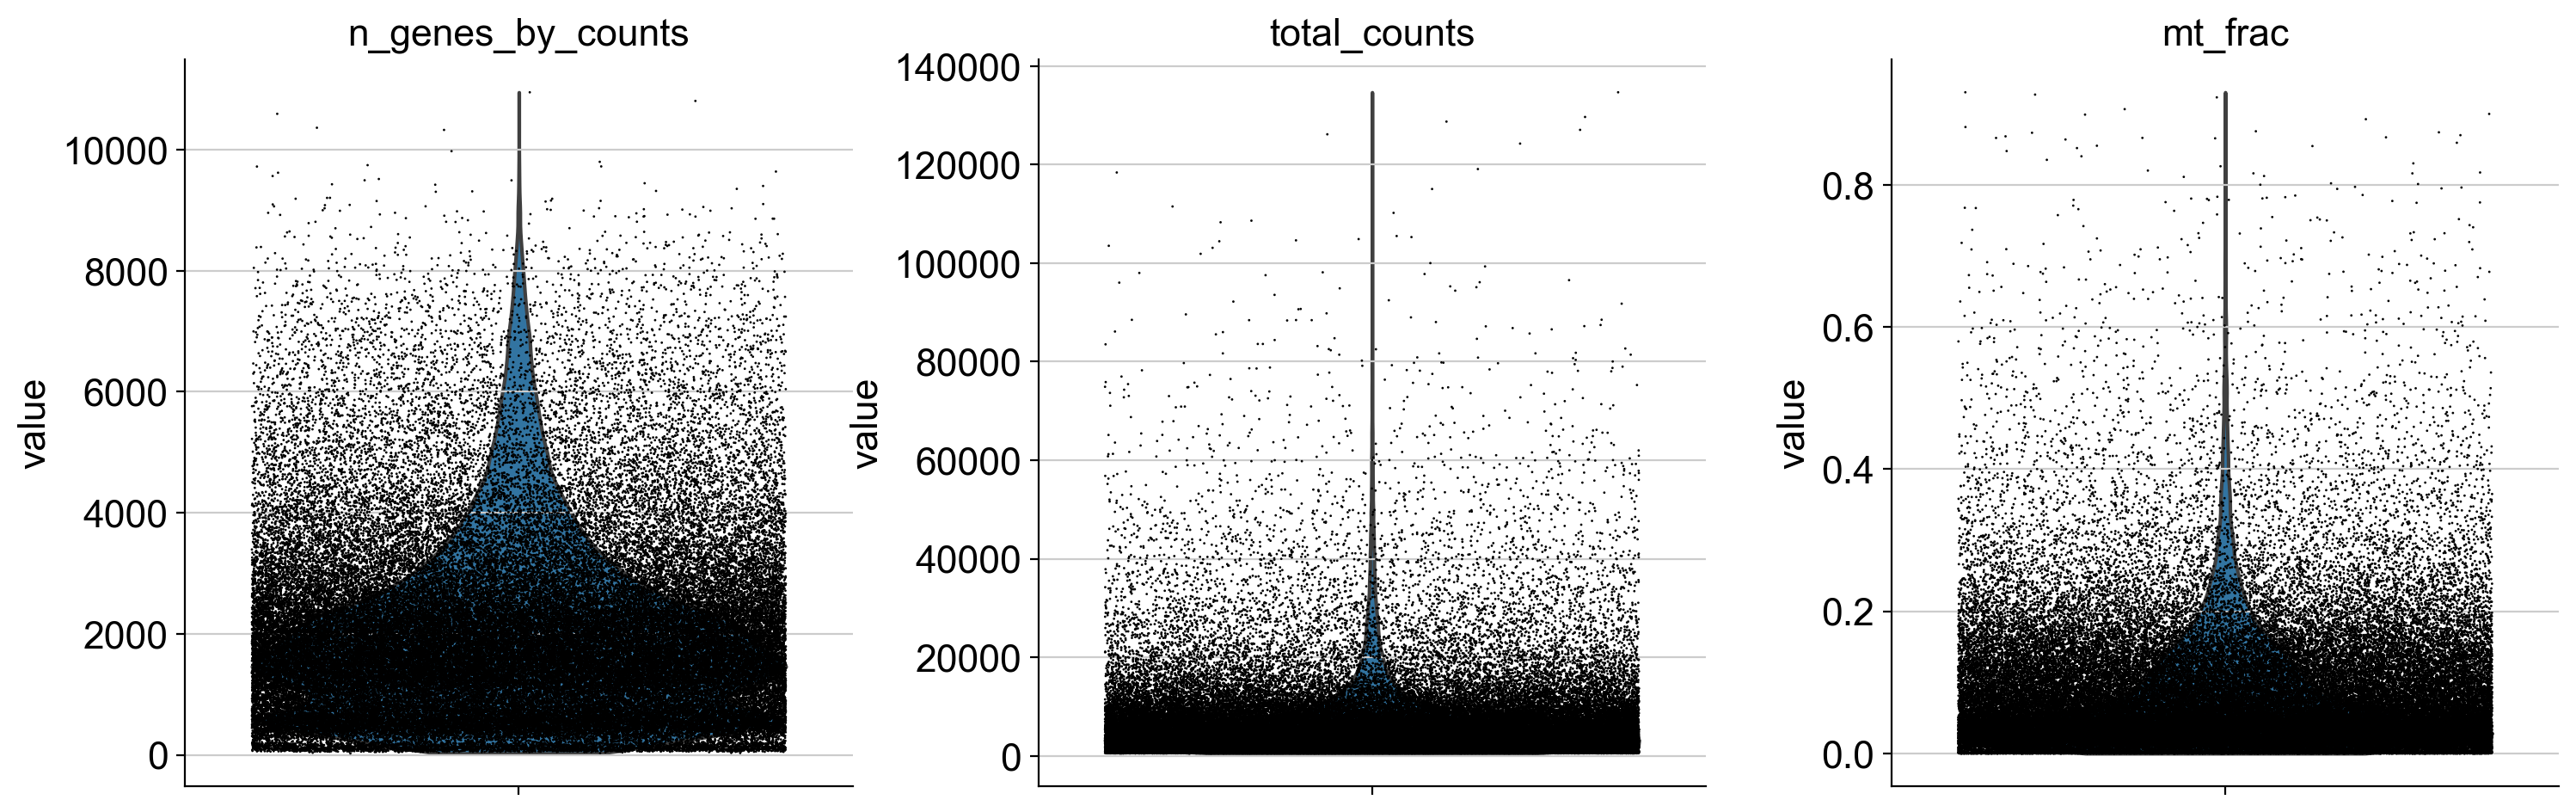

In [30]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'mt_frac'],
             jitter=0.4, multi_panel=True)

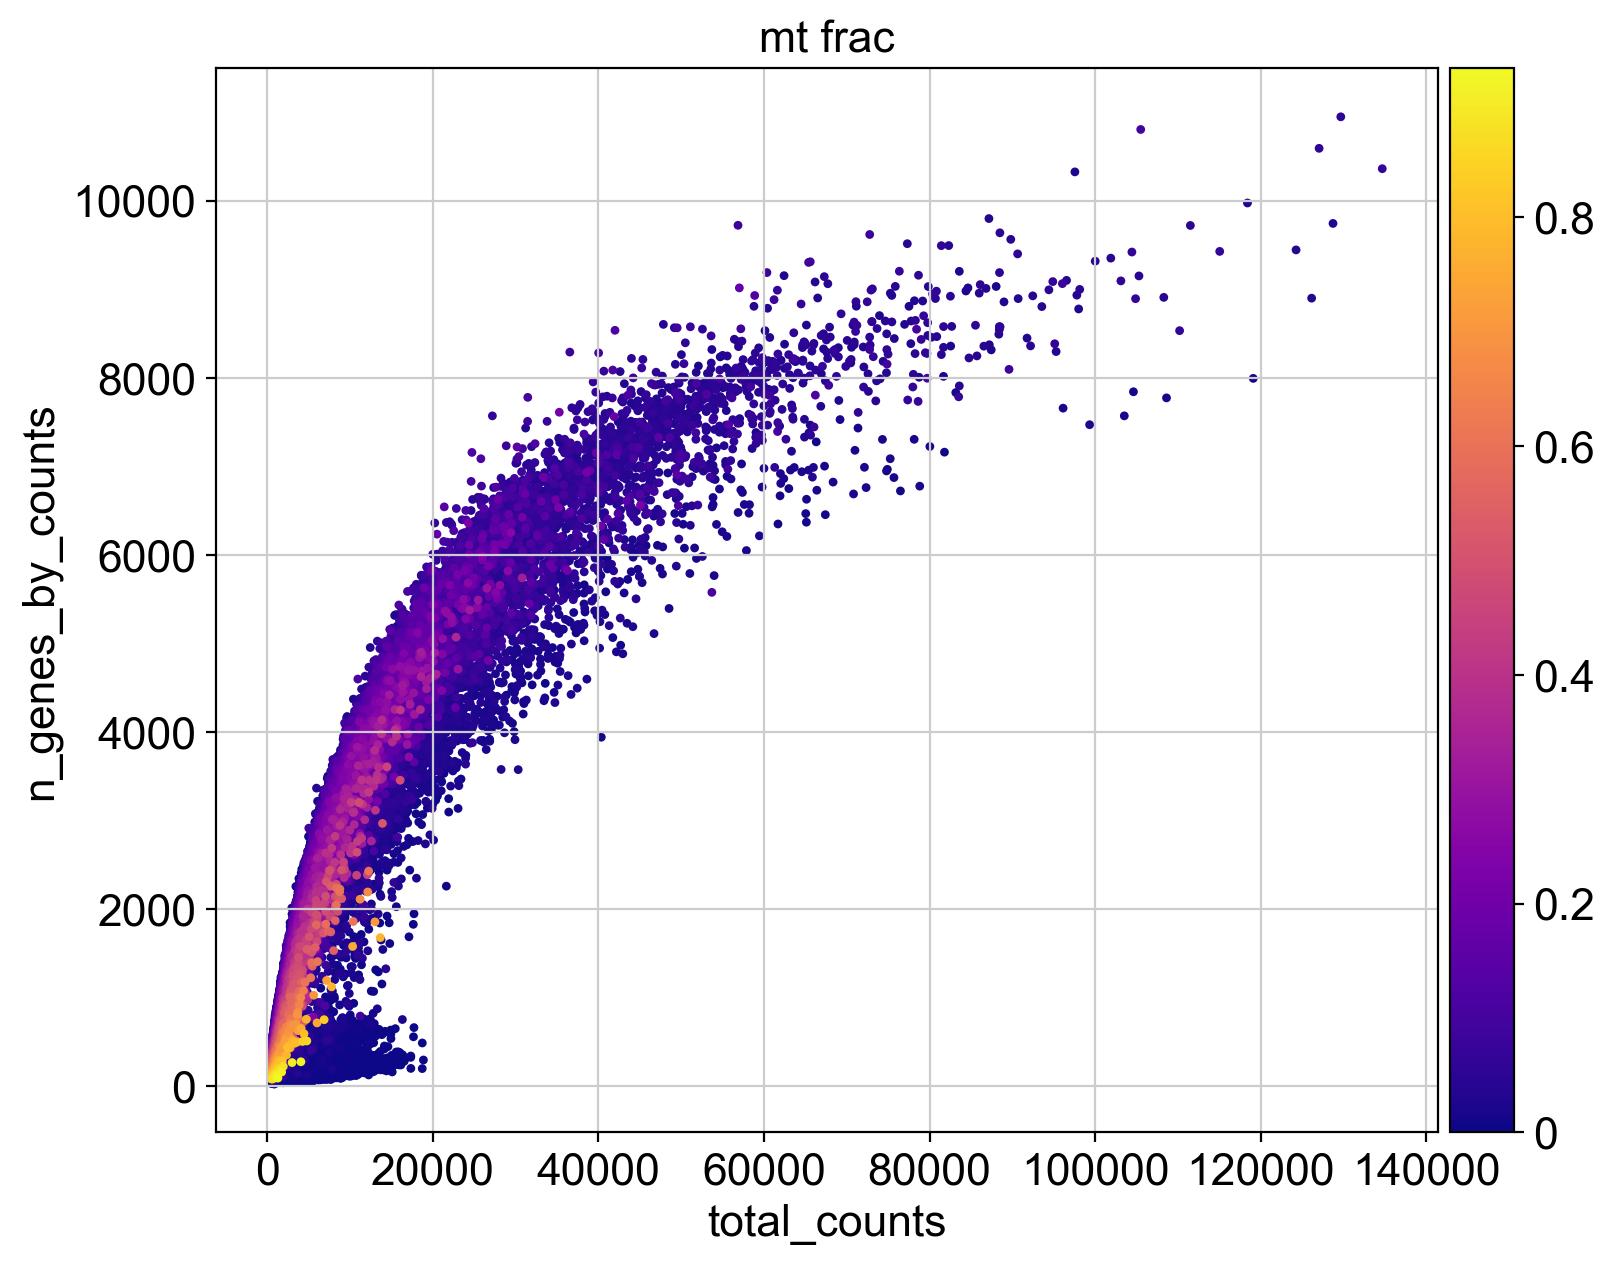

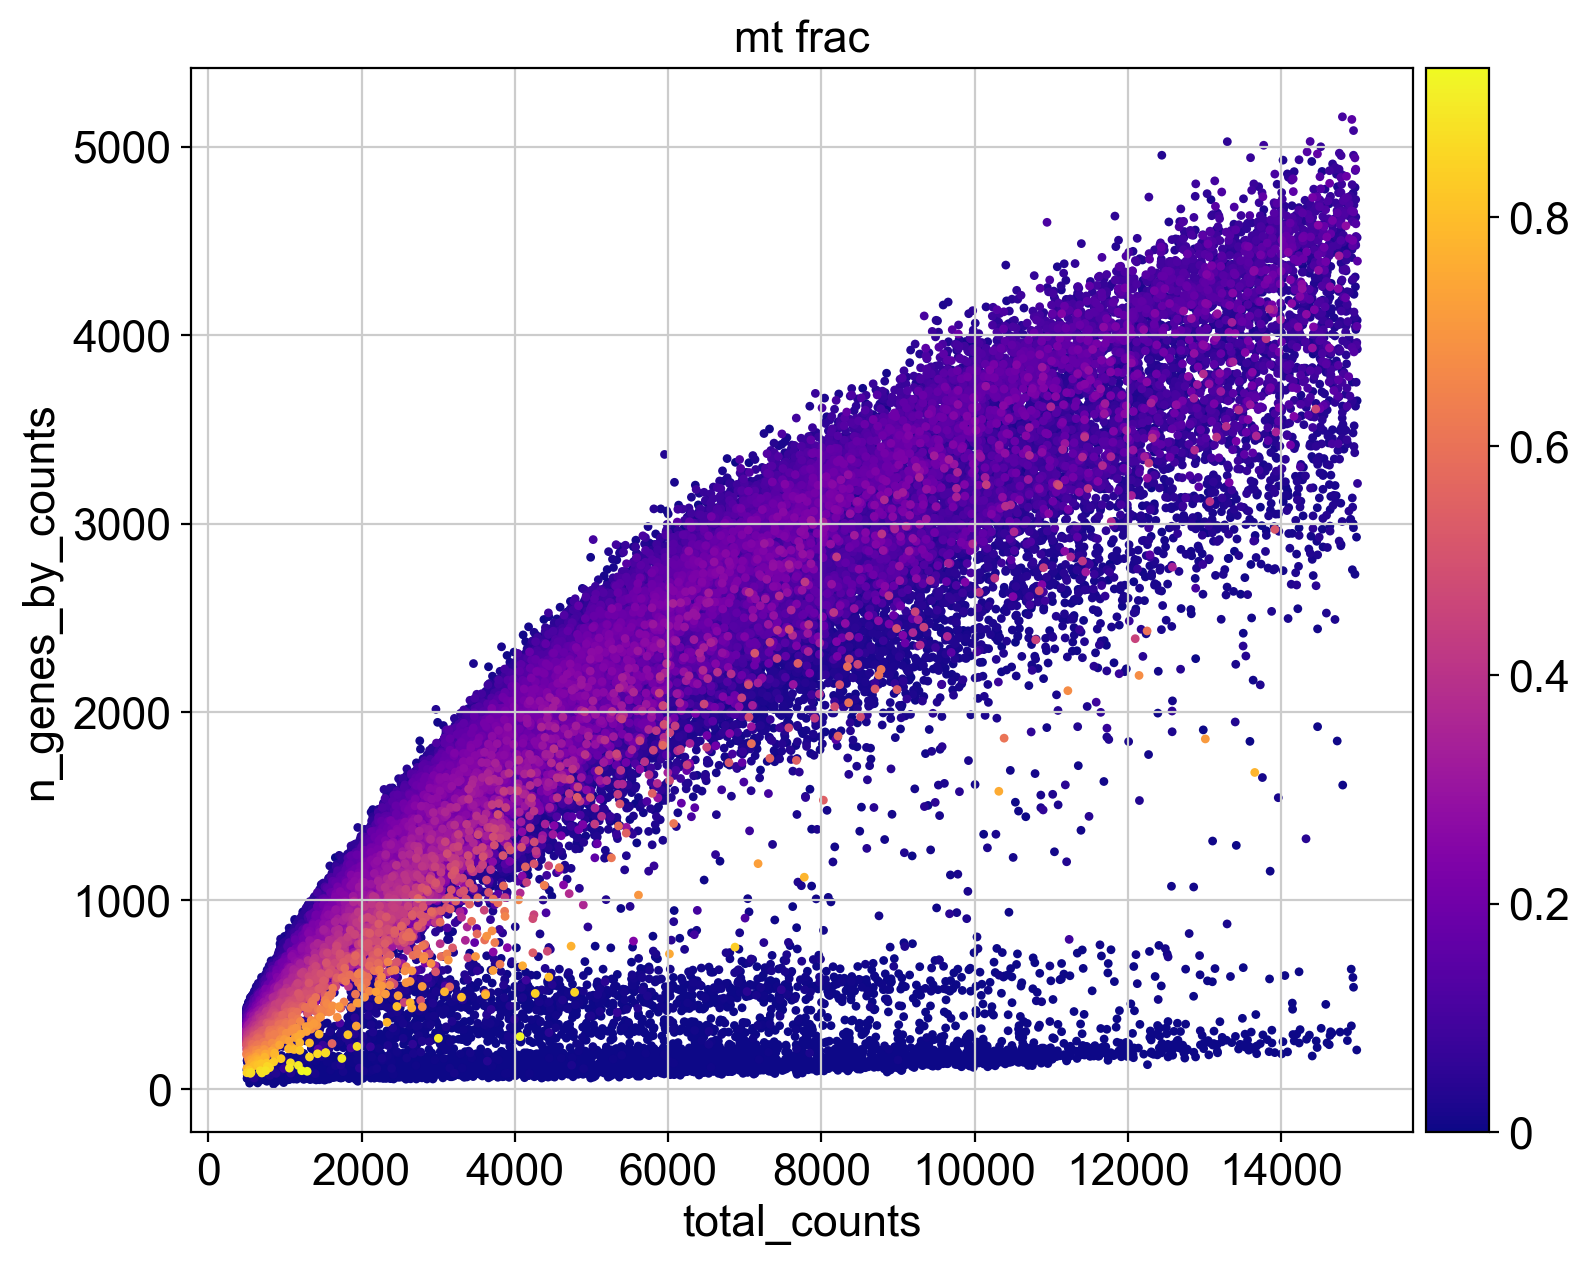

In [31]:
#Data quality summary plots
rcParams['figure.figsize']=(7,7)
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='mt_frac', size=40)
p2 = sc.pl.scatter(adata[adata.obs['total_counts']<15000], 'total_counts', 'n_genes_by_counts', 
                   color='mt_frac', size=40)

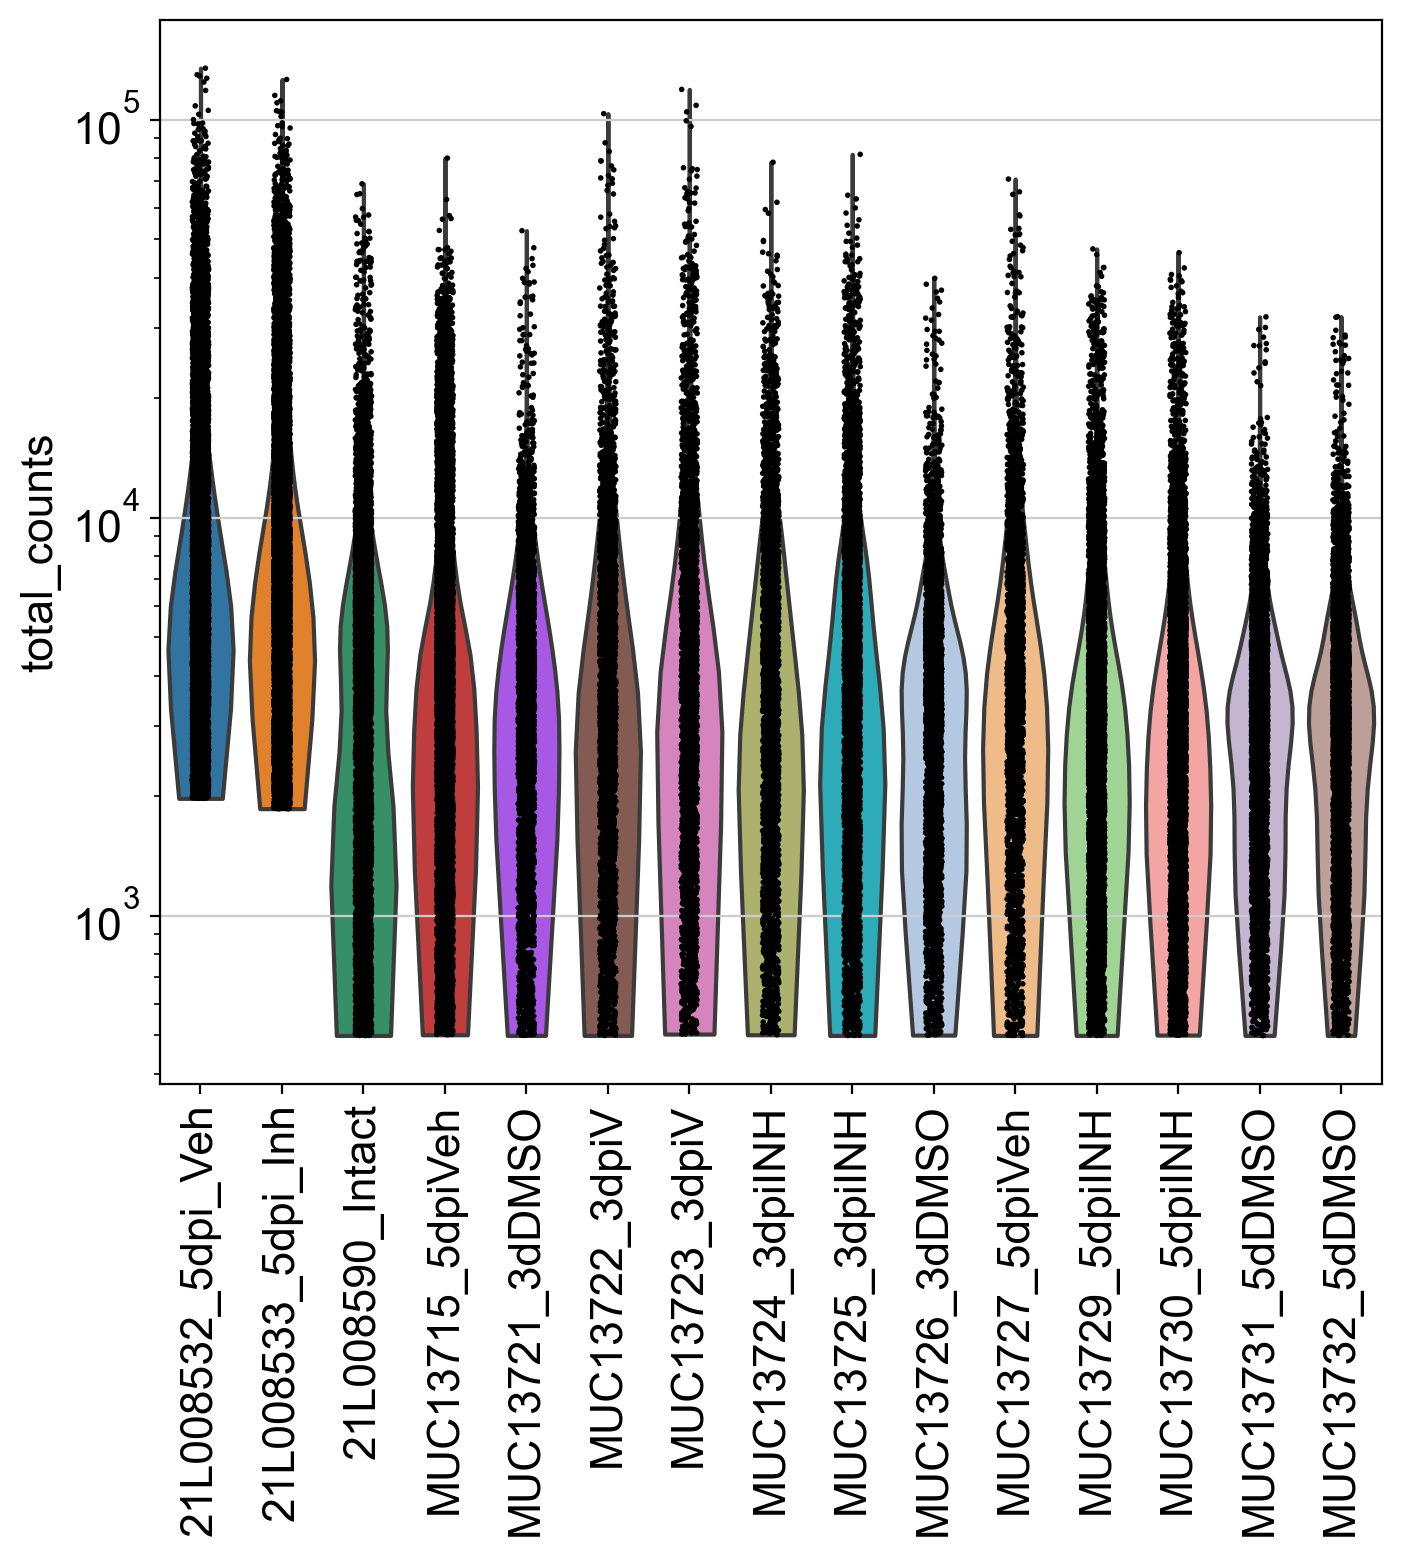

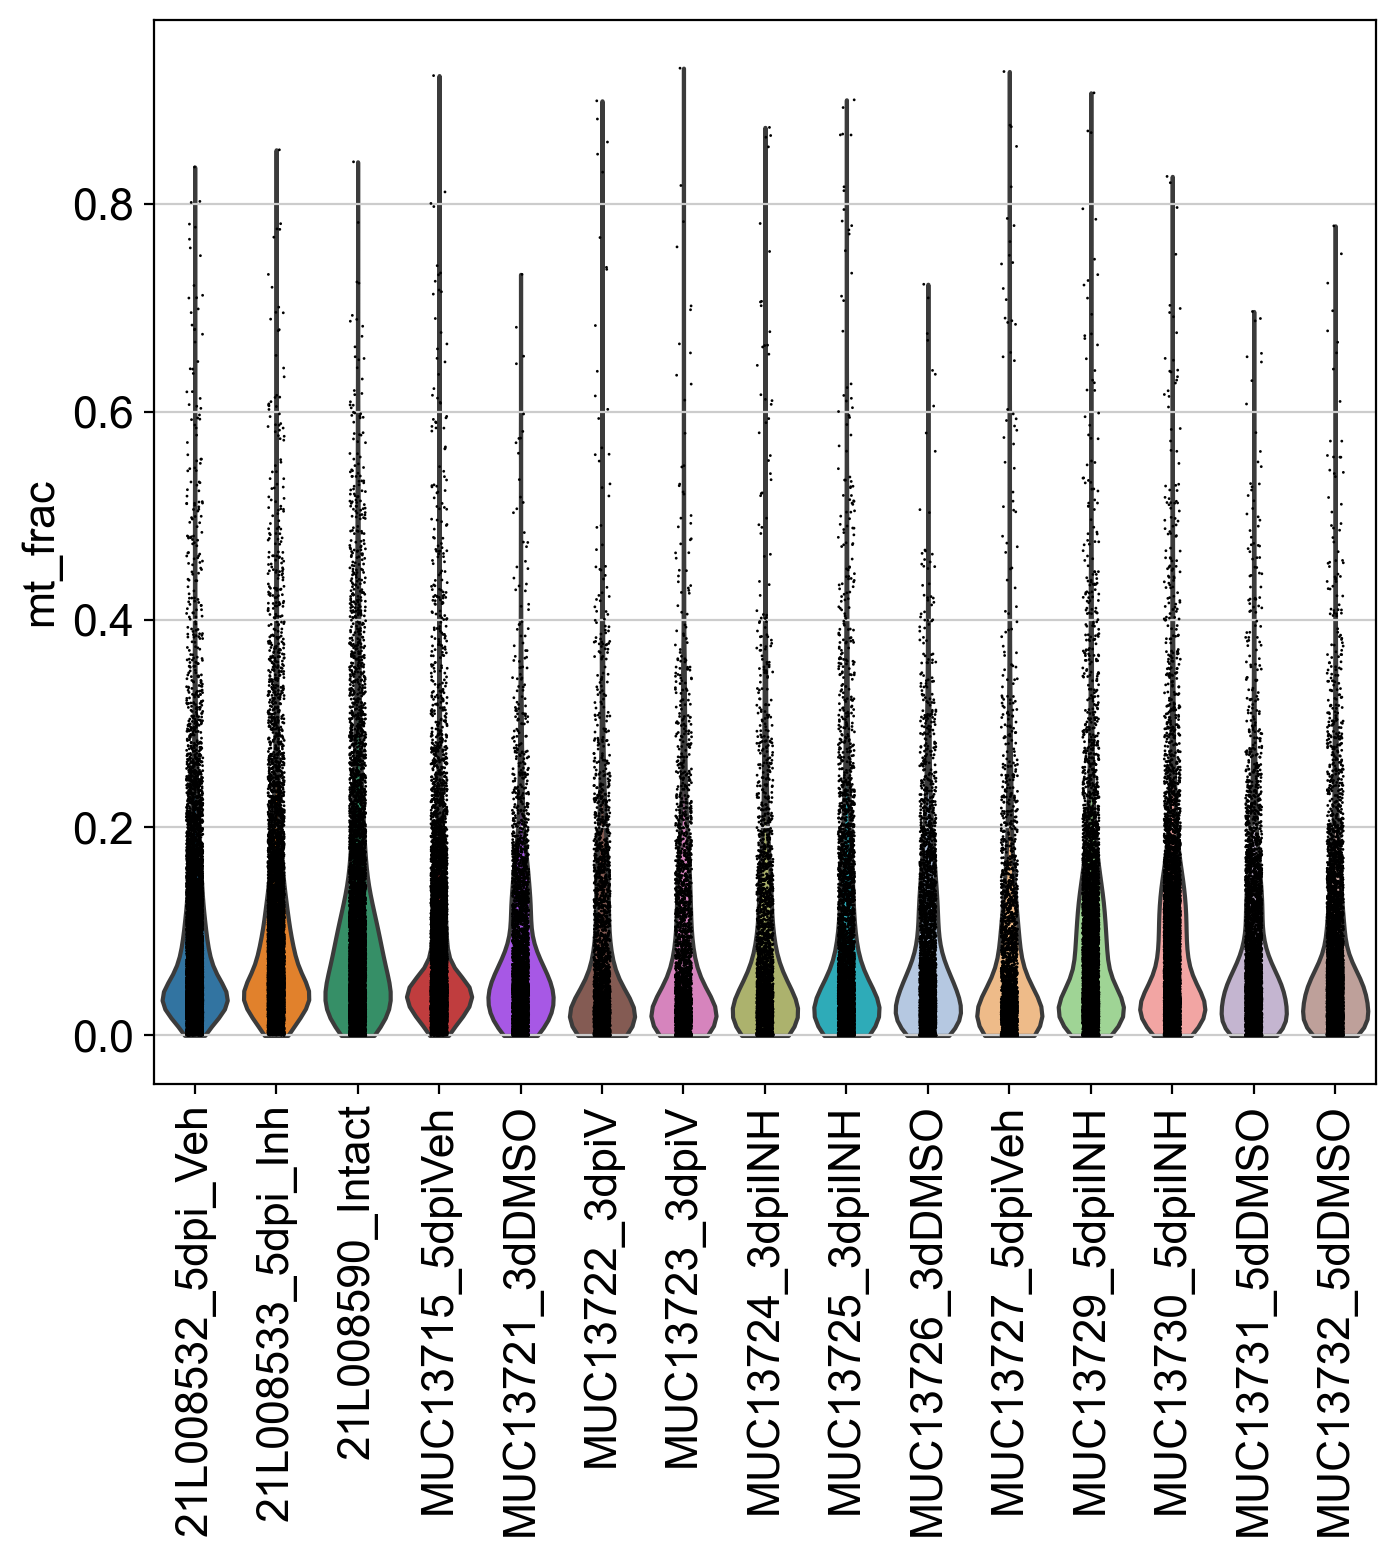

In [32]:
#Sample quality plots
rcParams['figure.figsize']=(7,7) #set figure size
t1 = sc.pl.violin(adata, 'total_counts',rotation=90,
                  groupby='sample_id_str',
                  size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac',rotation=90,
                  groupby='sample_id_str',)

normalizing counts per cell
    finished (0:00:01)


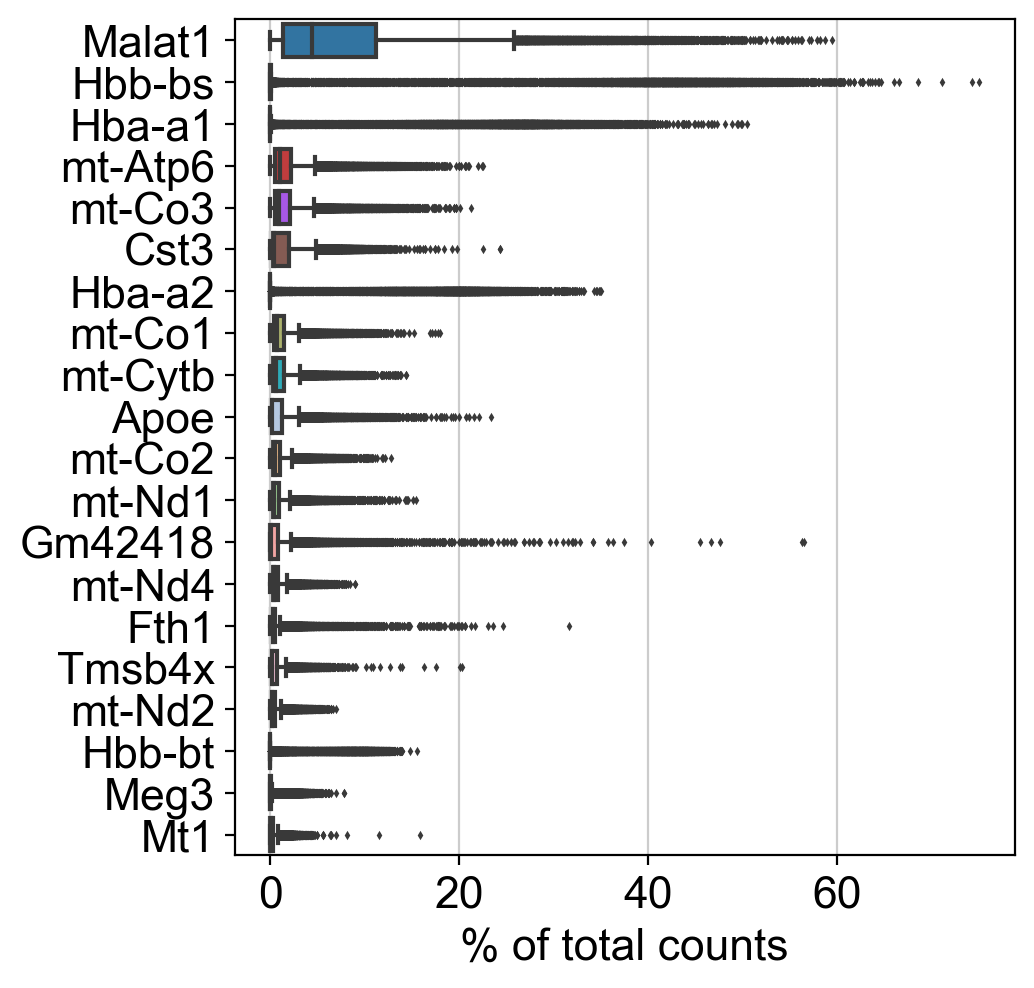

In [33]:
sc.pl.highest_expr_genes(adata, n_top=20)

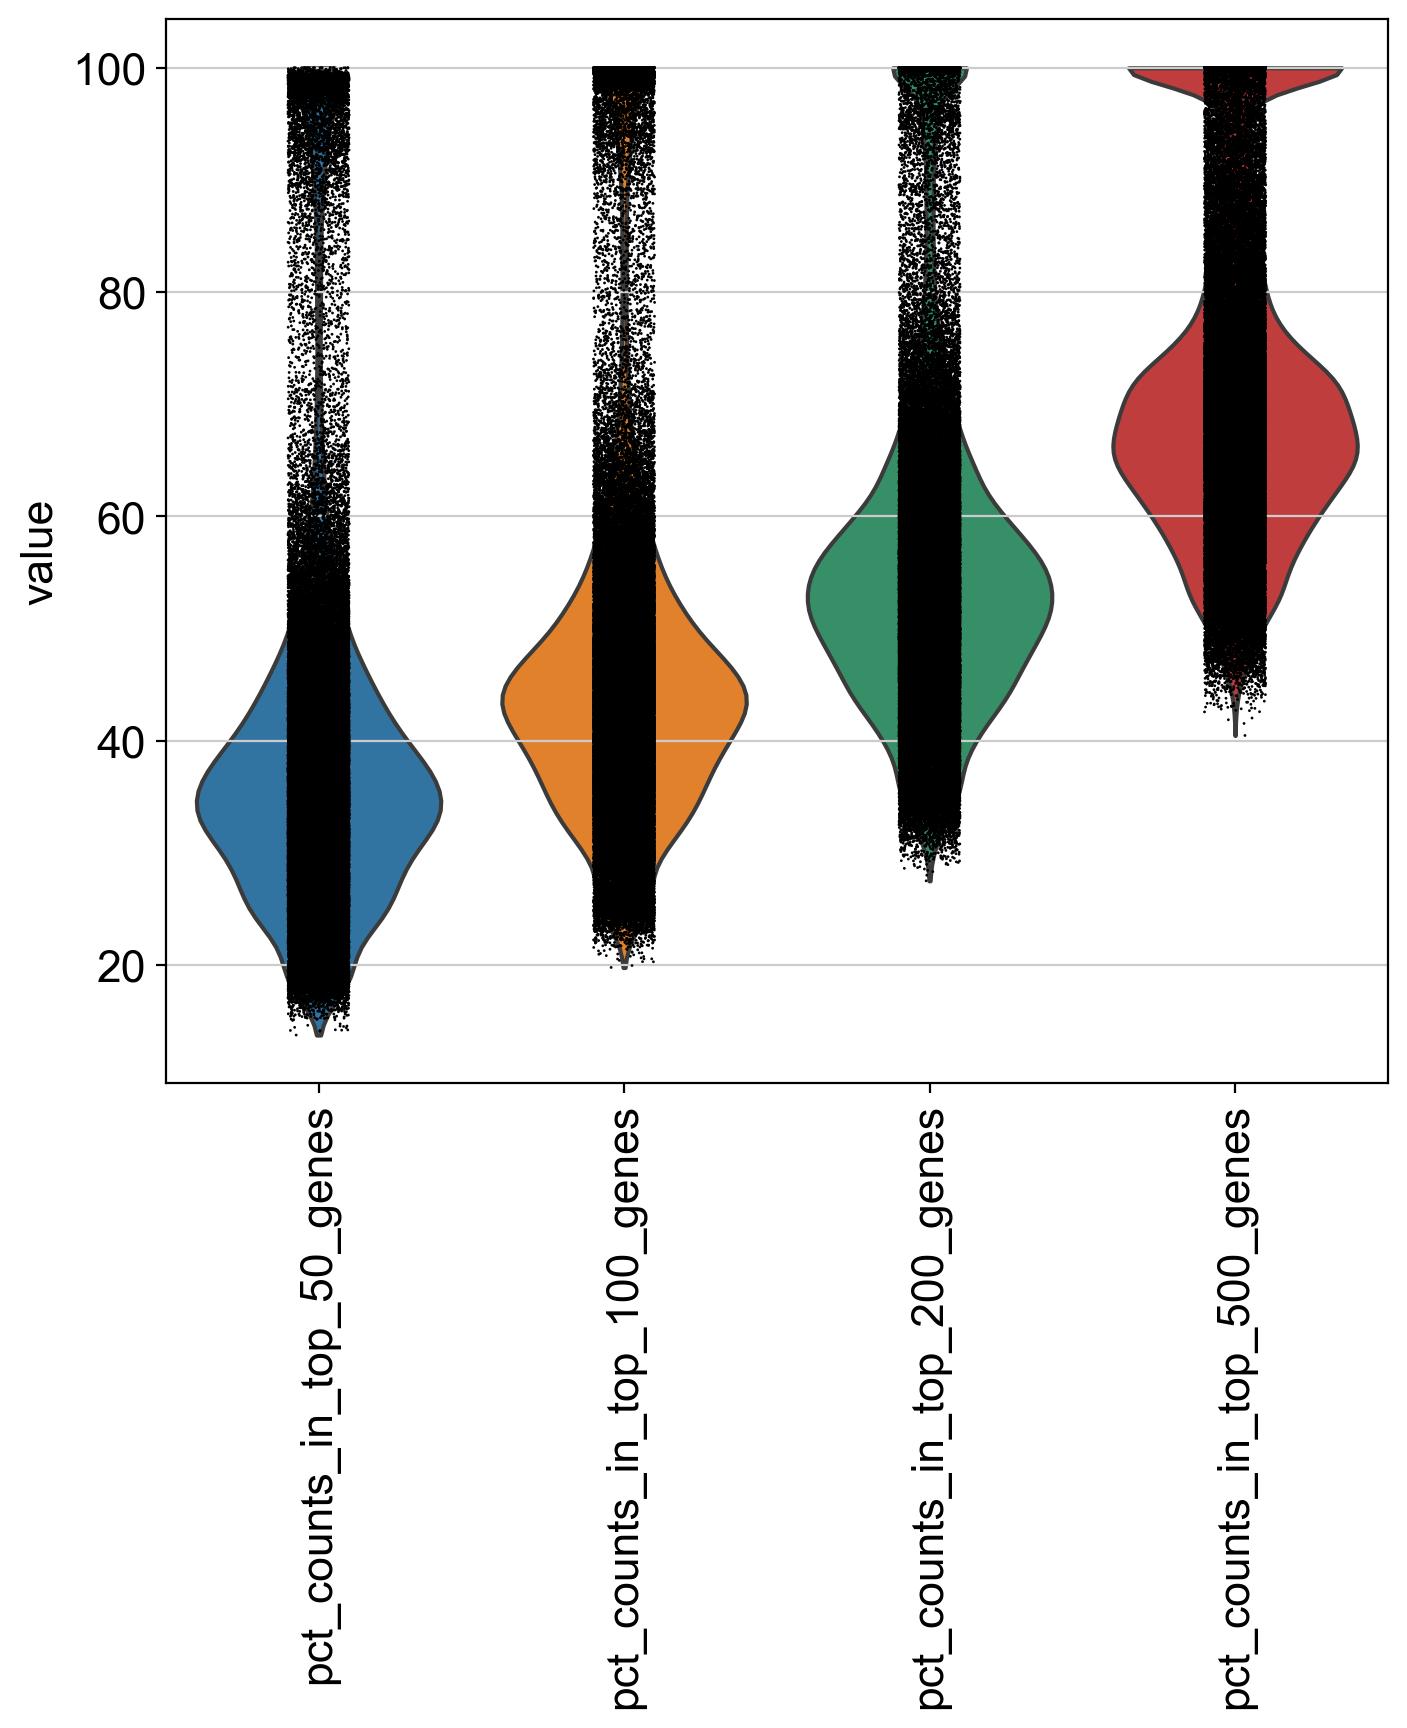

In [34]:
#Sample quality plots
rcParams['figure.figsize']=(7,7) #set figure size
t3 = sc.pl.violin(adata, keys=['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 
                     'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
                    ], rotation = 90)


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


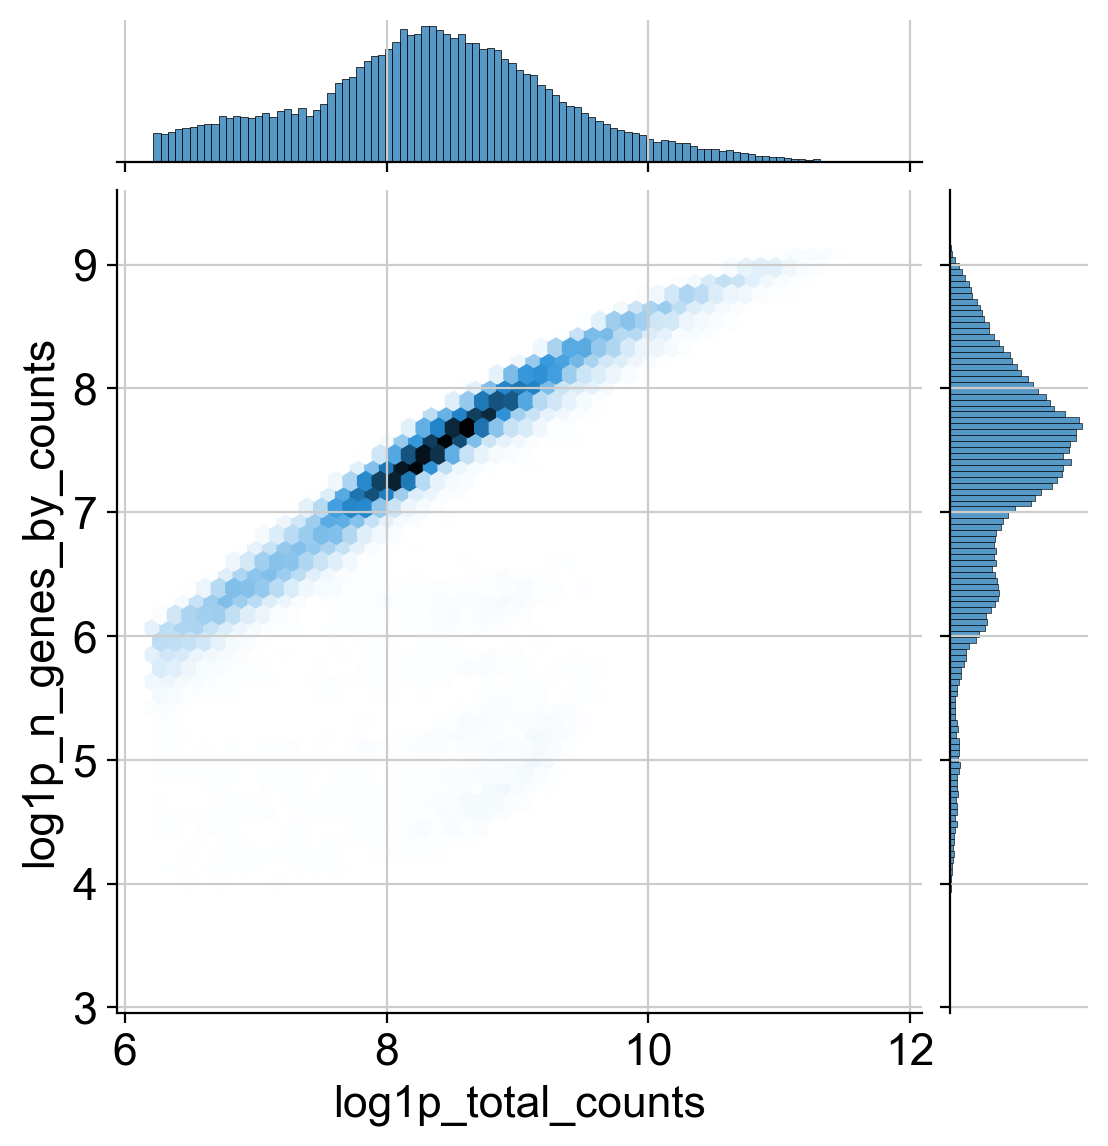

In [35]:
sb.jointplot(
        "log1p_total_counts", 
        "log1p_n_genes_by_counts",
        data=adata.obs, kind="hex"
    )

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


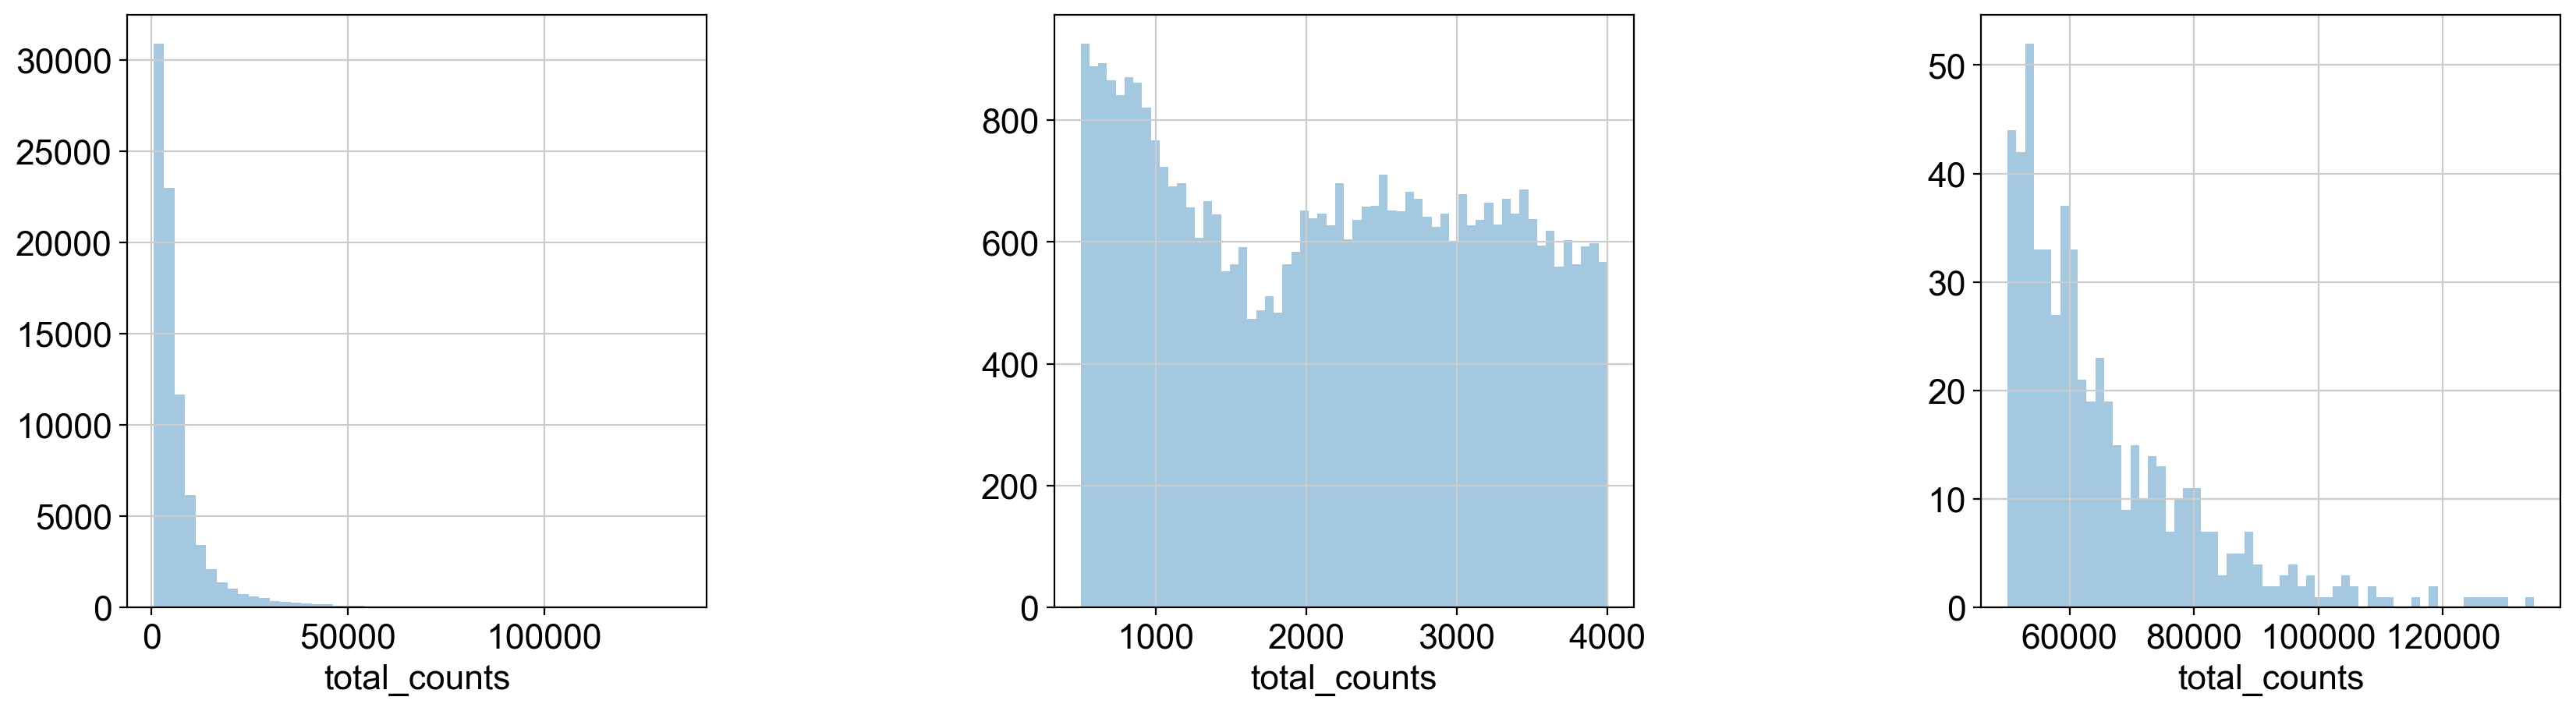

In [37]:
#Thresholding decision
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['total_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']>50000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


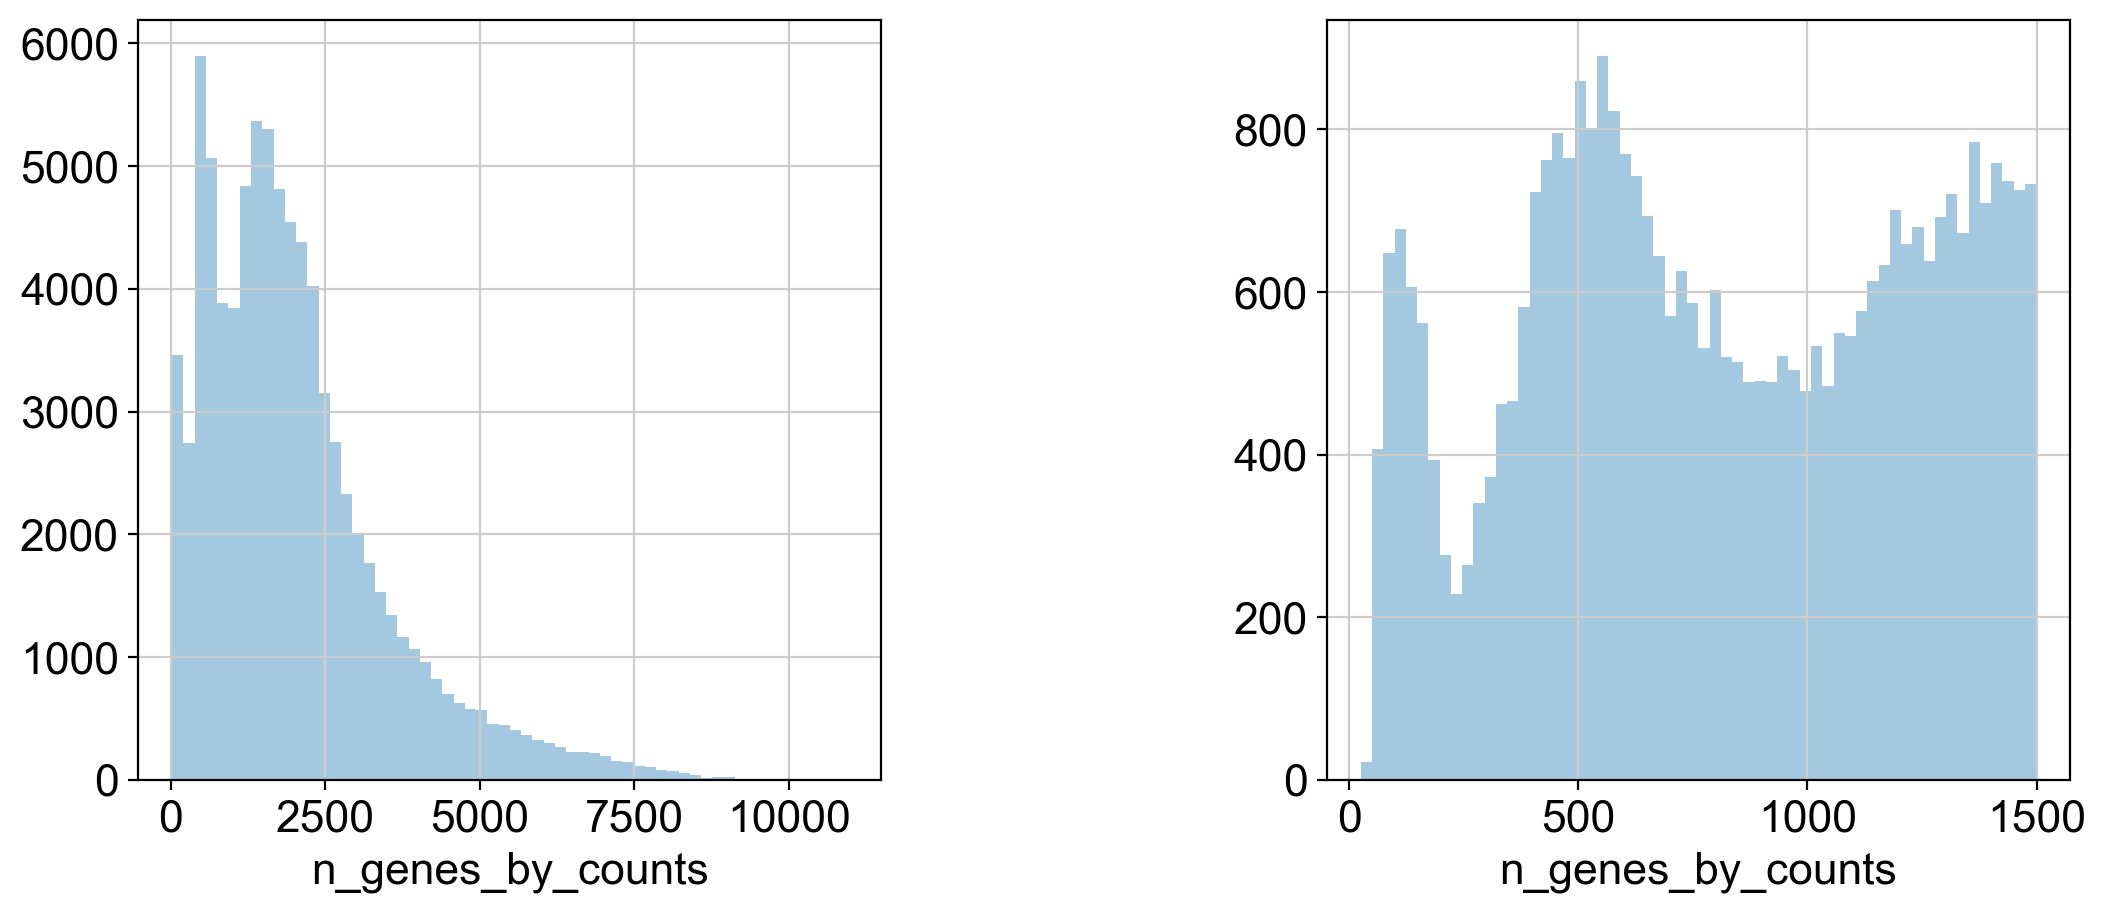

In [38]:
#Thresholding decision
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1500], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

In [40]:
adata_1 = adata[np.in1d(adata.obs['sample_id_str'],['MUC13721_3dDMSO','MUC13722_3dpiV', 'MUC13723_3dpiV', 'MUC13724_3dpiINH', 'MUC13725_3dpiINH'])].copy()
adata_2 = adata[np.in1d(adata.obs['sample_id_str'],['MUC13726_3dDMSO', 'MUC13727_5dpiVeh', 'MUC13729_5dpiINH', 'MUC13730_5dpiINH', 'MUC13731_5dDMSO', 'MUC13732_5dDMSO'])].copy()
adata_3 = adata[np.in1d(adata.obs['sample_id_str'],['MUC13715_5dpiVeh'])].copy()
adata_4 = adata[np.in1d(adata.obs['sample_id_str'],['21L008590_Intact'])].copy()
adata_5 = adata[np.in1d(adata.obs['sample_id_str'],['21L008532_5dpi_Veh', '21L008533_5dpi_Inh',])].copy()

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

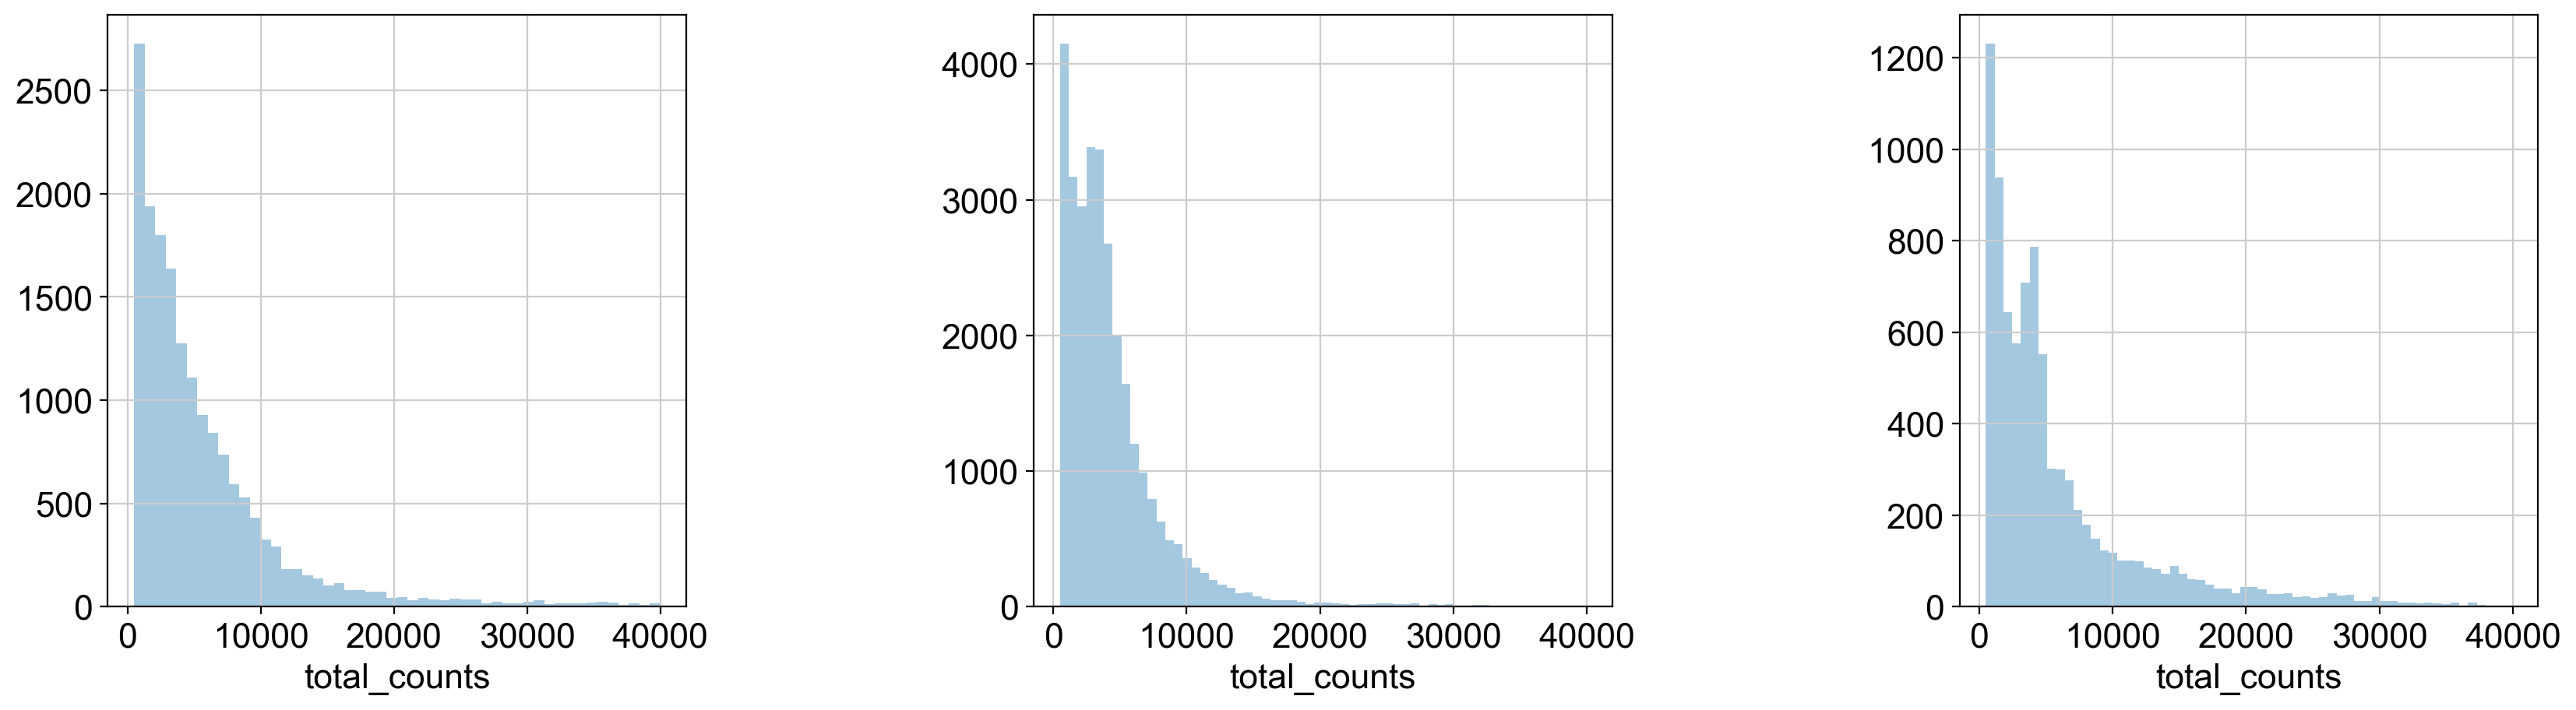

In [41]:
#Thresholding decision
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata_1.obs['total_counts'][adata_1.obs['total_counts']<40000], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata_2.obs['total_counts'][adata_2.obs['total_counts']<40000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata_3.obs['total_counts'][adata_3.obs['total_counts']<40000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))

plt.show()

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


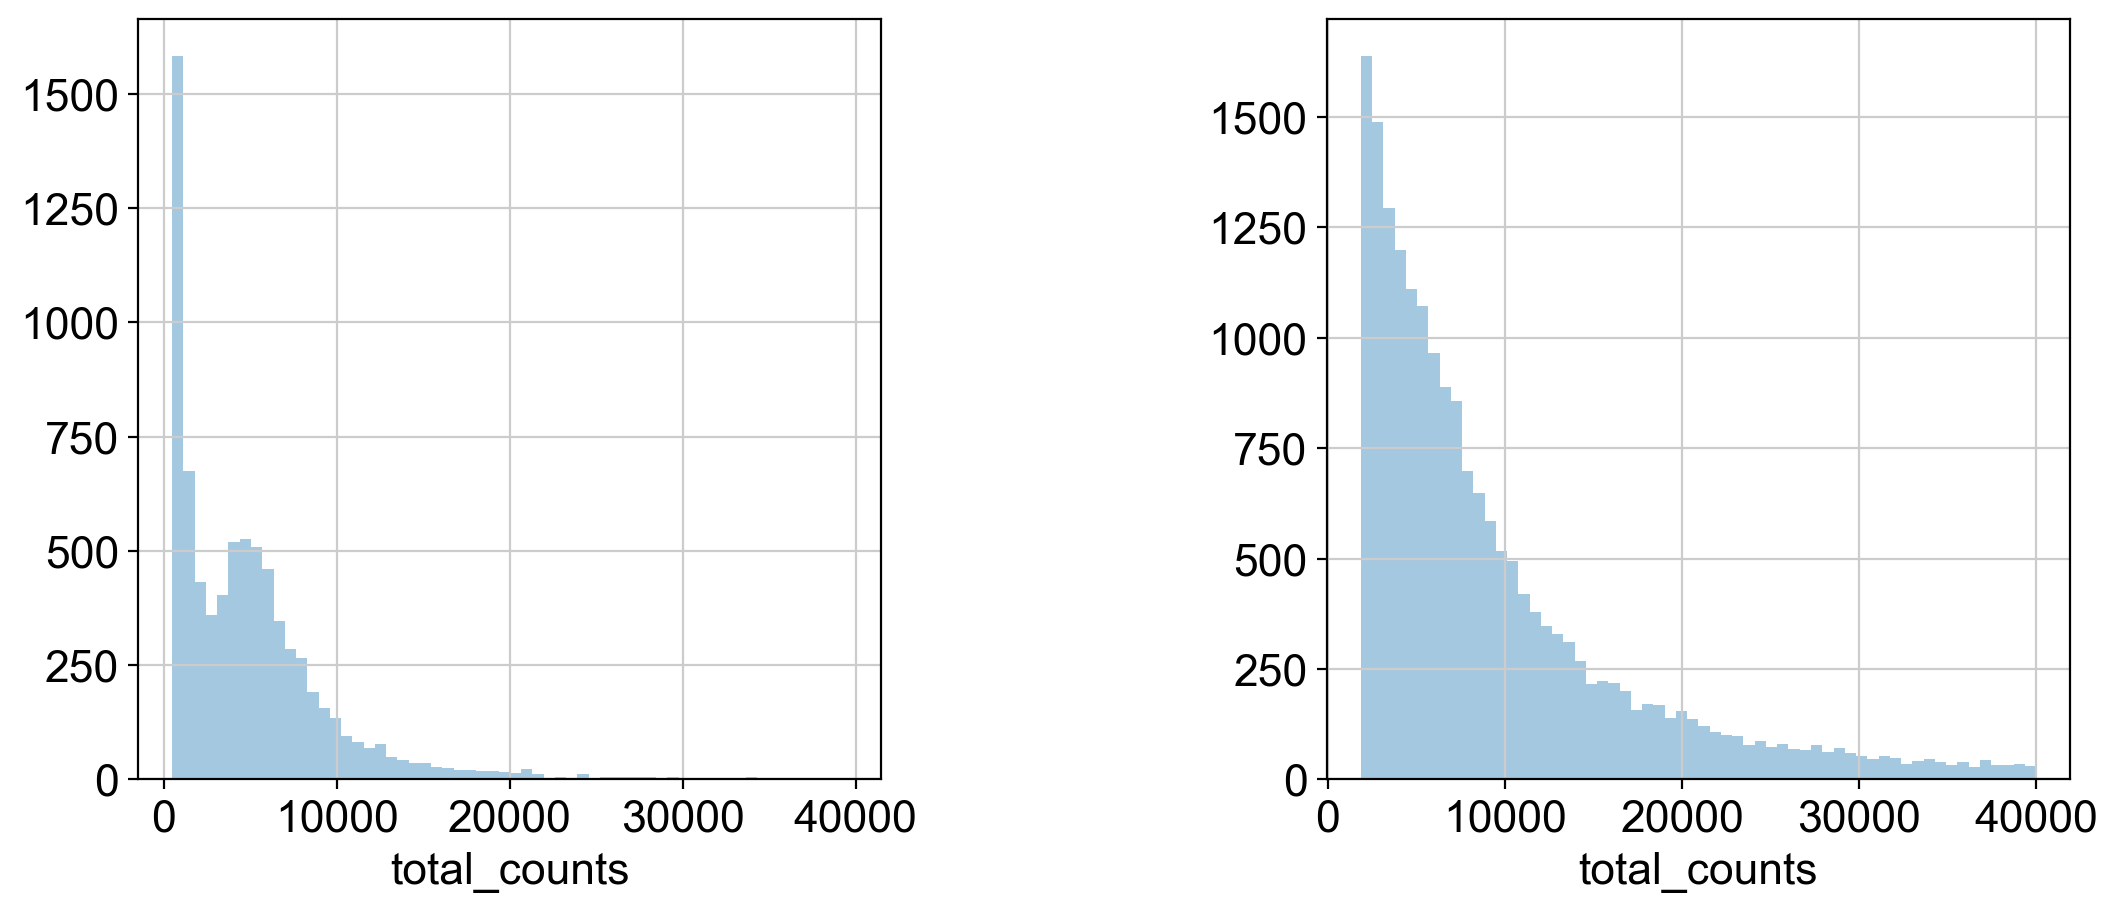

In [42]:
#Thresholding decision
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p6 = sb.distplot(adata_4.obs['total_counts'][adata_4.obs['total_counts']<40000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[0]))
p7 = sb.distplot(adata_5.obs['total_counts'][adata_5.obs['total_counts']<40000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
plt.show()

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


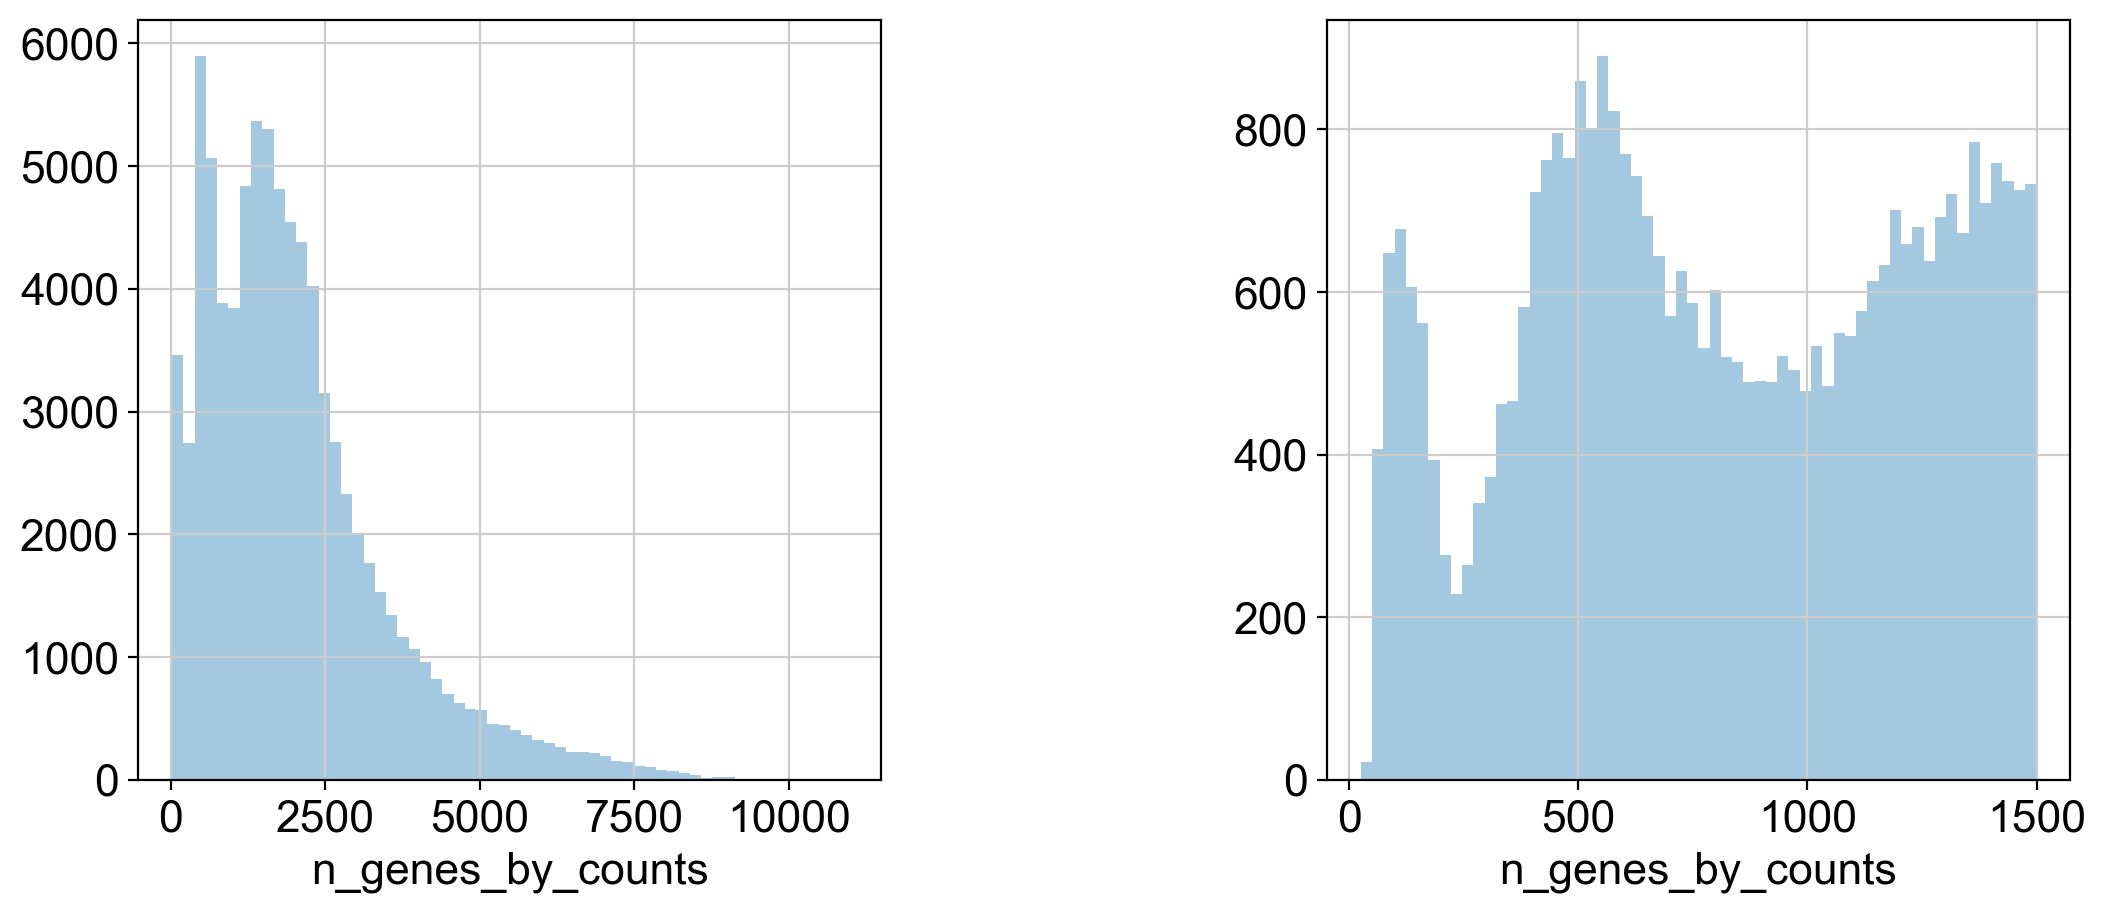

In [43]:
#Thresholding decision
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1500], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

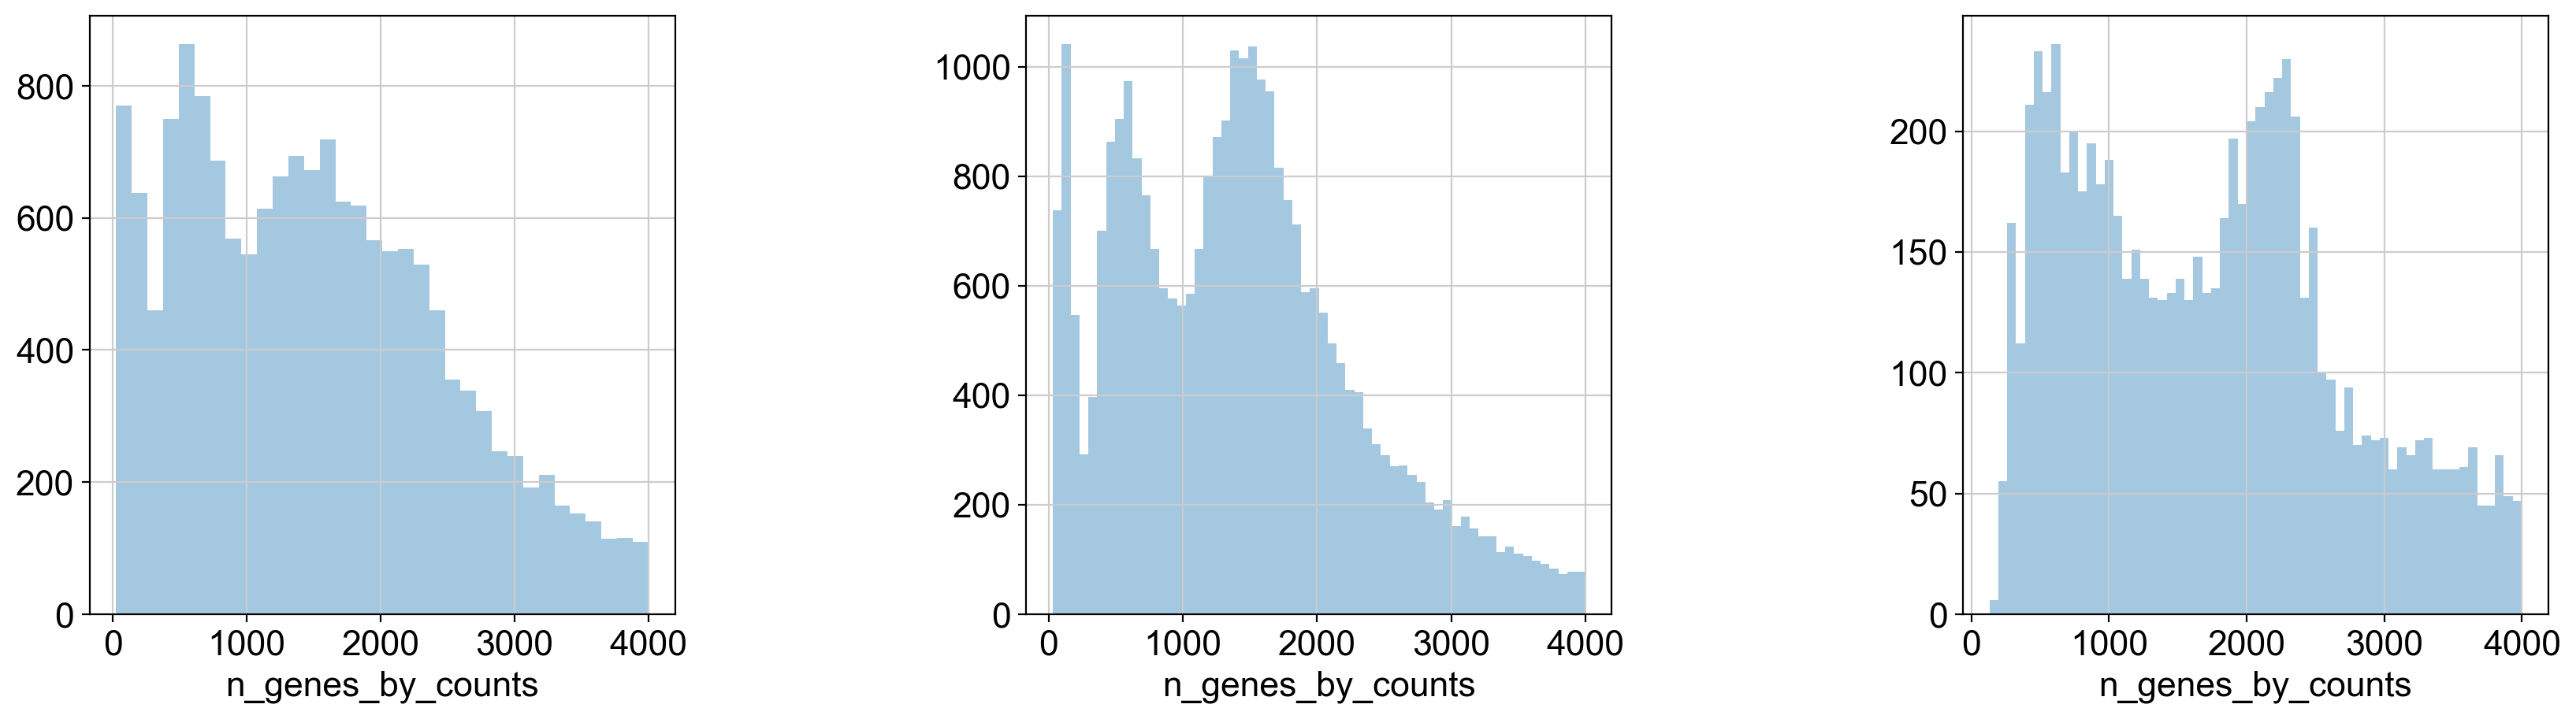

In [44]:
#Thresholding decision
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata_1.obs['n_genes_by_counts'][adata_1.obs['n_genes_by_counts']<4000], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]))
p4 = sb.distplot(adata_2.obs['n_genes_by_counts'][adata_2.obs['n_genes_by_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
p5 = sb.distplot(adata_3.obs['n_genes_by_counts'][adata_3.obs['n_genes_by_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))

plt.show()

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


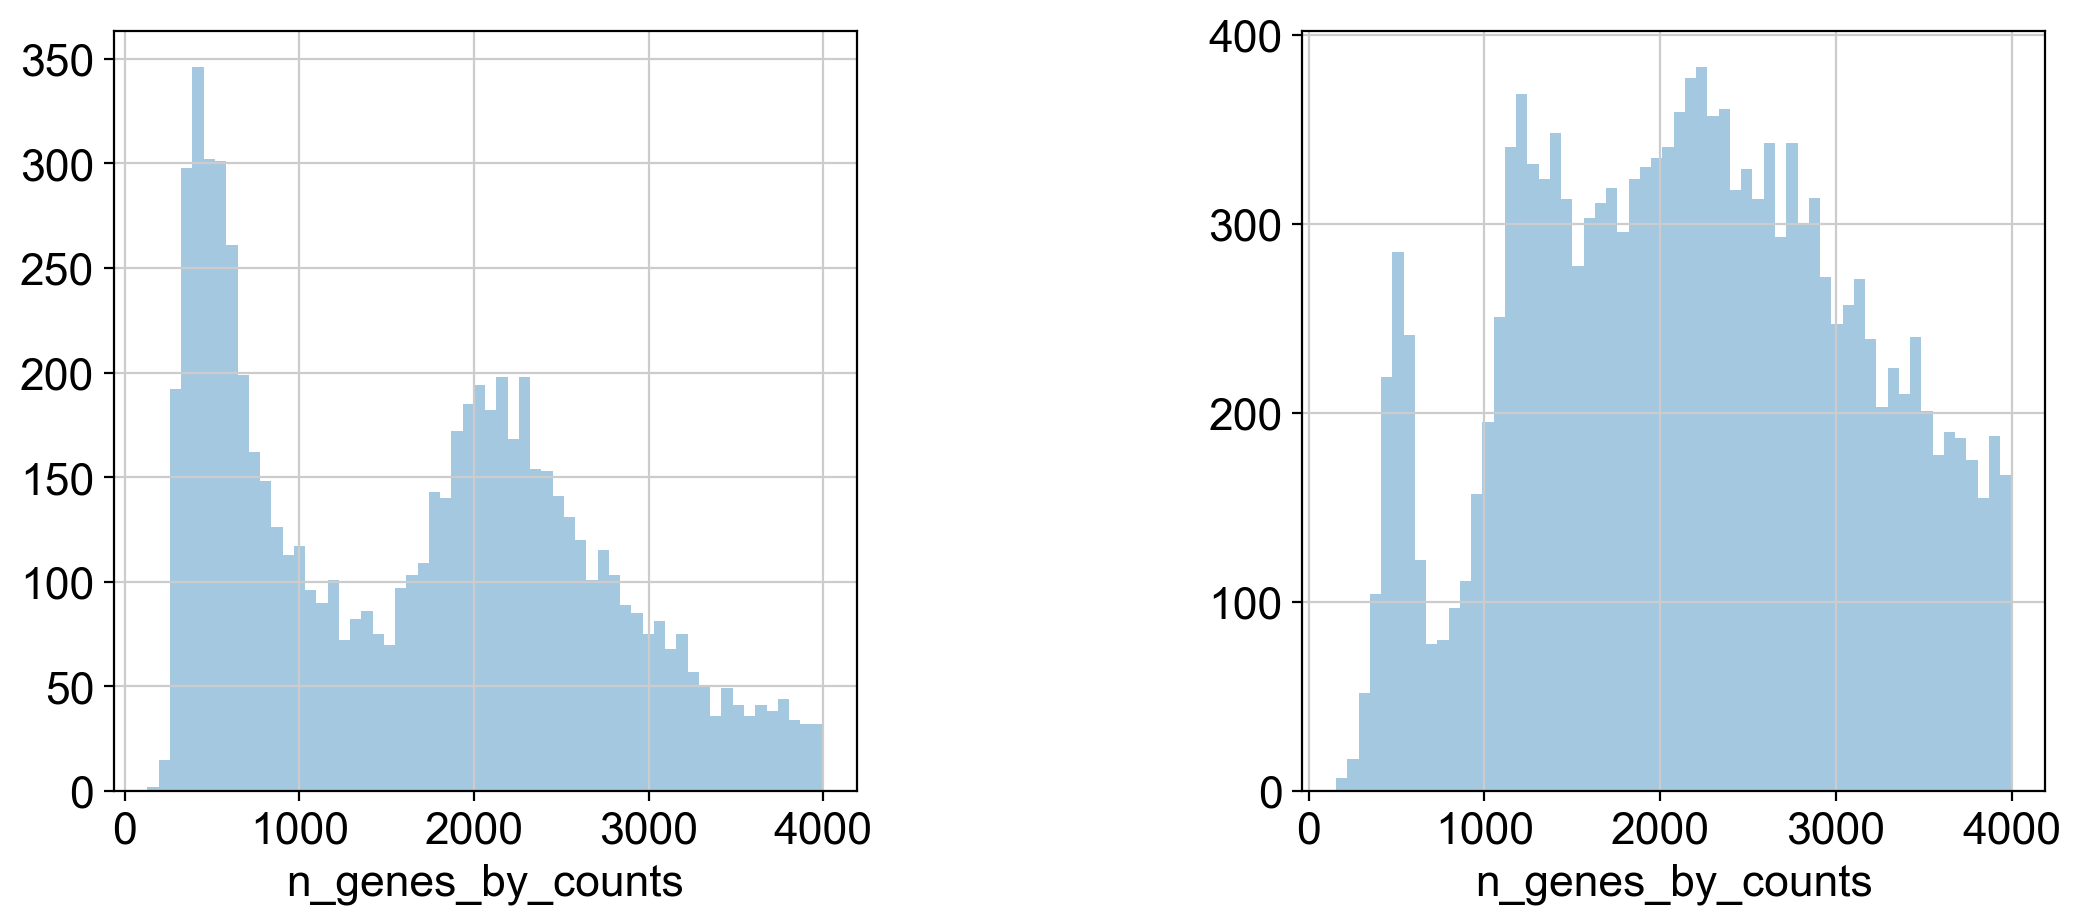

In [45]:
#Thresholding decision
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p6 = sb.distplot(adata_4.obs['n_genes_by_counts'][adata_4.obs['n_genes_by_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[0]))
p7 = sb.distplot(adata_5.obs['n_genes_by_counts'][adata_5.obs['n_genes_by_counts']<4000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[1]))
plt.show()

Create a histogram for the fraction of mitochondrial genes. Further, create a histogram for the high fraction regime, each.

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


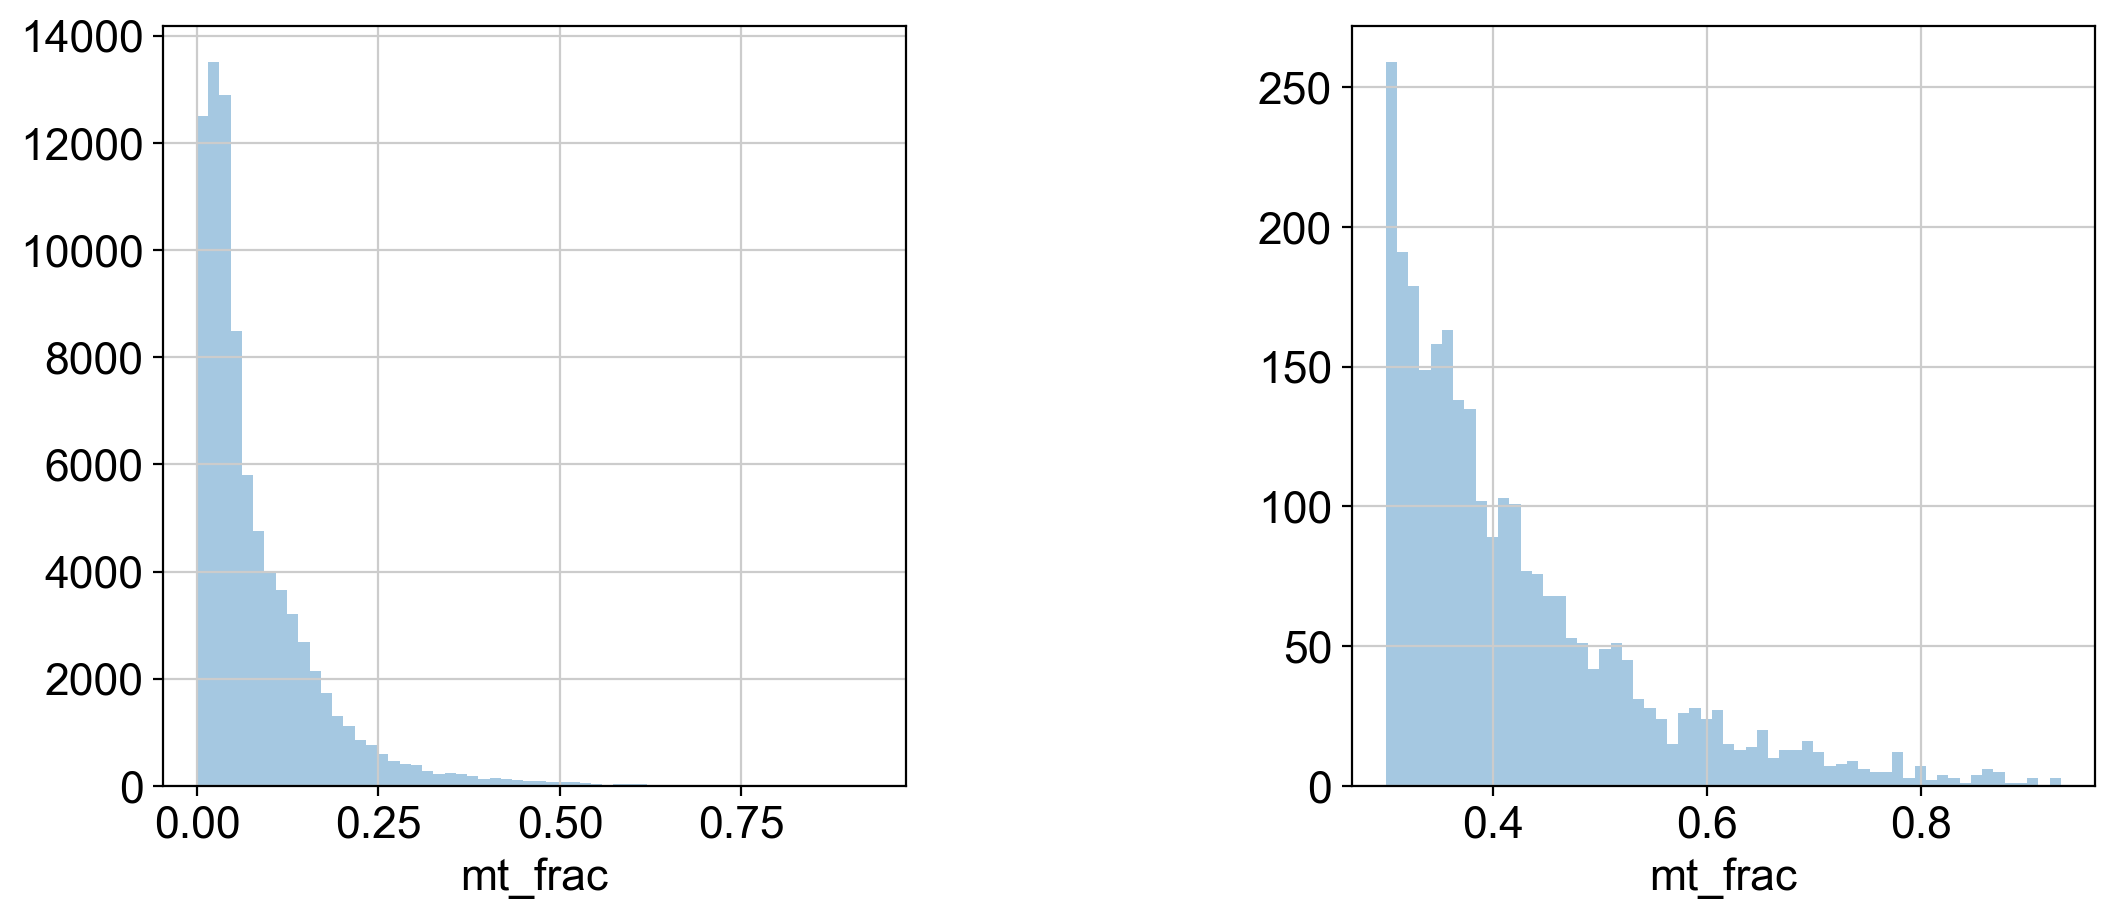

In [46]:
#Thresholding decision: mitochondrial reads

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac']>0.3], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

In [47]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 50000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.25]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 1000)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 83833
filtered out 574 cells that have more than 50000 counts
Number of cells after max count filter: 83259
Number of cells after MT filter: 78941
filtered out 19421 cells that have less than 1000 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 59520


In [48]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 8708 genes that are detected in less than 20 cells
Number of genes after cell filter: 19290


### Doublet score

In [49]:
adata.obs['doublet_score']= np.zeros(adata.shape[0])
adata.obs['doublet'] = np.zeros(adata.shape[0])

In [50]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02 
sim_doublet_ratio = 3
n_neighbors = 15



scrub = scr.Scrublet(counts_matrix = adata.X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)

doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)

adata.obs['doublet_score'] = doublet_scores
adata.obs['doublet'] = predicted_doublets


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.13
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 45.3%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.3%
Elapsed time: 80.6 seconds


/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


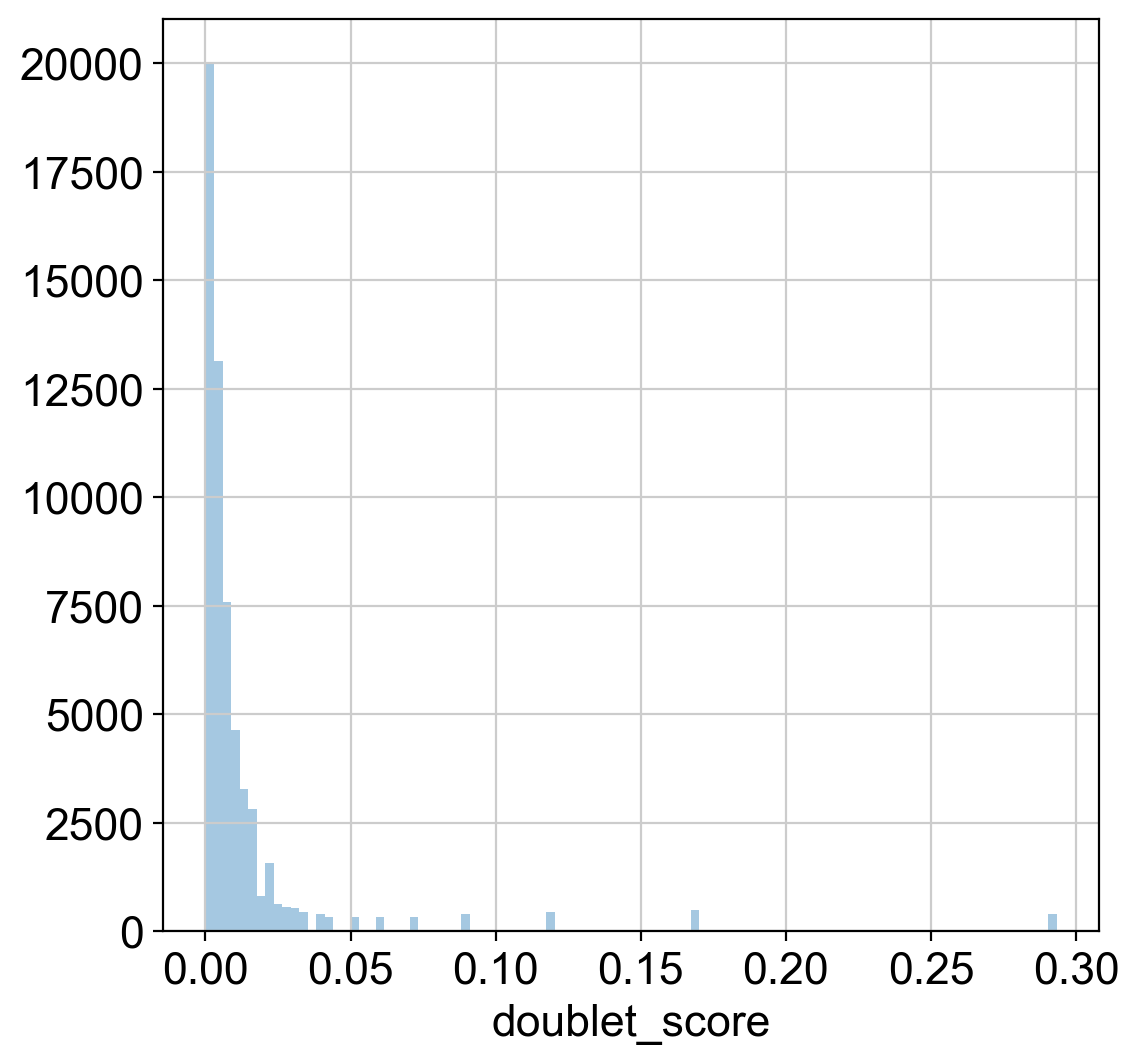

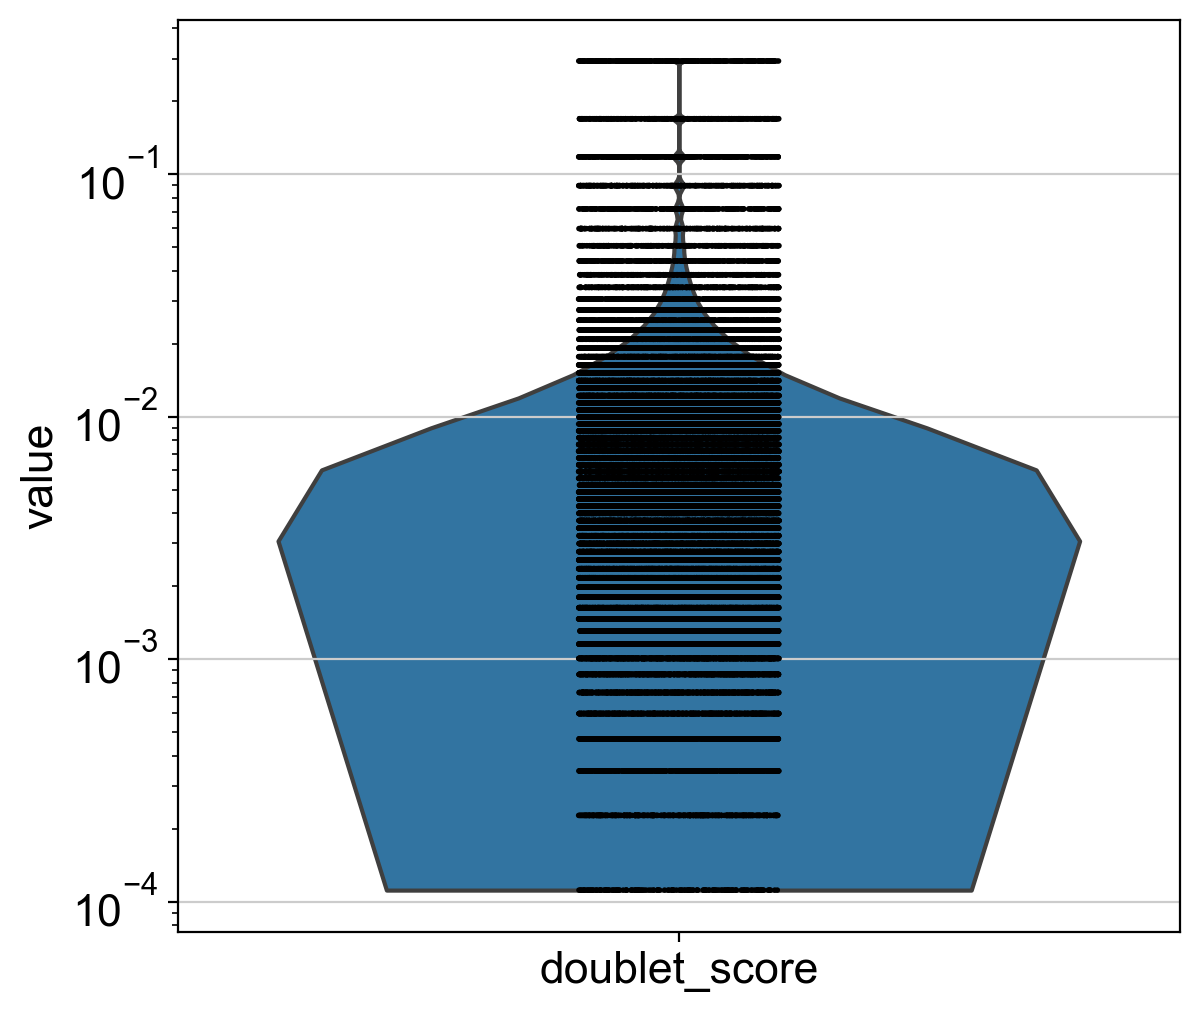

In [51]:
rcParams['figure.figsize']=(6,6)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False)
plt.show()


sc.pl.violin(adata, 'doublet_score',
                  size=2, log=True, cut=0)

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


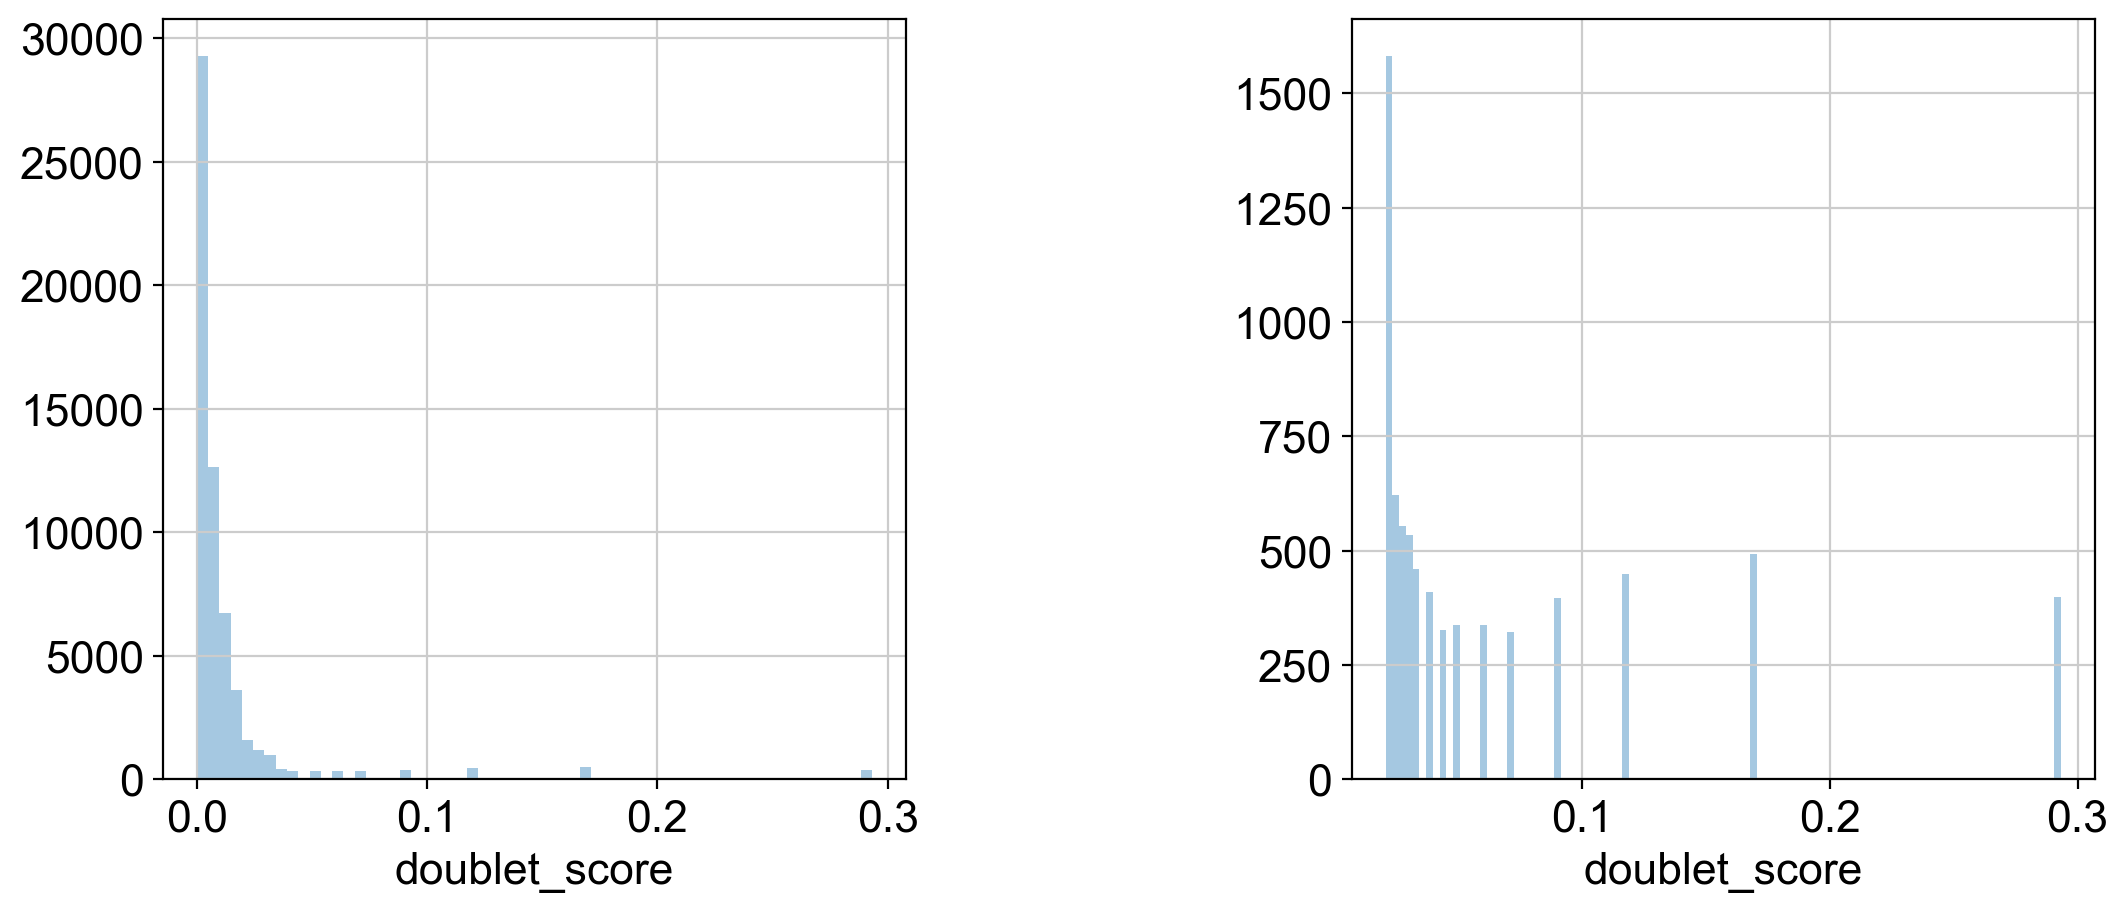

In [52]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['doublet_score'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['doublet_score'][adata.obs['doublet_score']>0.02], 
                 kde=False, bins=100, ax=fig.add_subplot(fig_ind[1]))
plt.show()

### filtering doublets

In [53]:
thr = 0.05
ix_filt = adata.obs['doublet_score']<=thr

adata = adata[ix_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells after doublet filter: 56786


### Summarize sample information

In [54]:
adata

AnnData object with n_obs × n_vars = 56786 × 19290
    obs: 'sample_id', 'sample_id_str', 'condition', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'doublet_score', 'doublet'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_id_str_colors'

In [55]:
adata.obs['condition'] = adata.obs['sample_id_str'].map(sample_id_str2condition).astype('category')

In [56]:
#dooble check annotation
pd.crosstab(adata.obs['sample_id_str'],adata.obs['condition'])

condition           3dpi_I  3dpi_V  5dpi_I  5dpi_V  Intact
sample_id_str                                             
21L008532_5dpi_Veh       0       0       0    8308       0
21L008533_5dpi_Inh       0       0    7910       0       0
21L008590_Intact         0       0       0       0    4660
MUC13715_5dpiVeh         0       0       0    5874       0
MUC13721_3dDMSO          0       0       0       0    2676
MUC13722_3dpiV           0    1850       0       0       0
MUC13723_3dpiV           0    1796       0       0       0
MUC13724_3dpiINH      1867       0       0       0       0
MUC13725_3dpiINH      2750       0       0       0       0
MUC13726_3dDMSO          0       0       0       0    2474
MUC13727_5dpiVeh         0       0       0    1716       0
MUC13729_5dpiINH         0       0    3836       0       0
MUC13730_5dpiINH         0       0    3914       0       0
MUC13731_5dDMSO          0       0       0       0    3389
MUC13732_5dDMSO          0       0       0       0    3766

In [57]:
df = adata.obs[['n_genes_by_counts','total_counts', 'batch']]
df_all = pd.DataFrame(df.groupby(by='batch')['n_genes_by_counts'].apply(np.mean).values,
                      index=df.groupby(by='batch')['n_genes_by_counts'].apply(np.mean).index,
                      columns=['mean_genes'])

df_all['median_genes']=df.groupby(by='batch')['n_genes_by_counts'].apply(np.median).values
df_all['mean_counts']=df.groupby(by='batch')['total_counts'].apply(np.mean).values
df_all['median_counts']=df.groupby(by='batch')['total_counts'].apply(np.median).values
df_all

mean_genes  median_genes   mean_counts  median_counts
batch                                                        
1      2317.128805        2031.0   7608.946289         5359.0
2      2023.408484        1744.0   5566.244141         4170.0
3      2595.687606        2265.0   7955.892578         4924.5
4      2517.510300        2289.0   7031.278320         5657.5
5      3140.014367        2765.0  10681.934570         7406.0

In [58]:
#df_all.to_csv(table_dir + today+'data_overview_earlytp.csv')

In [59]:
#adata.write(data_dir +today+ 'data_postQC_all_earlytp.h5ad')

## Normalization

In [60]:
rcParams['figure.figsize']=(5,5)

In [61]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [62]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 22 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:14)


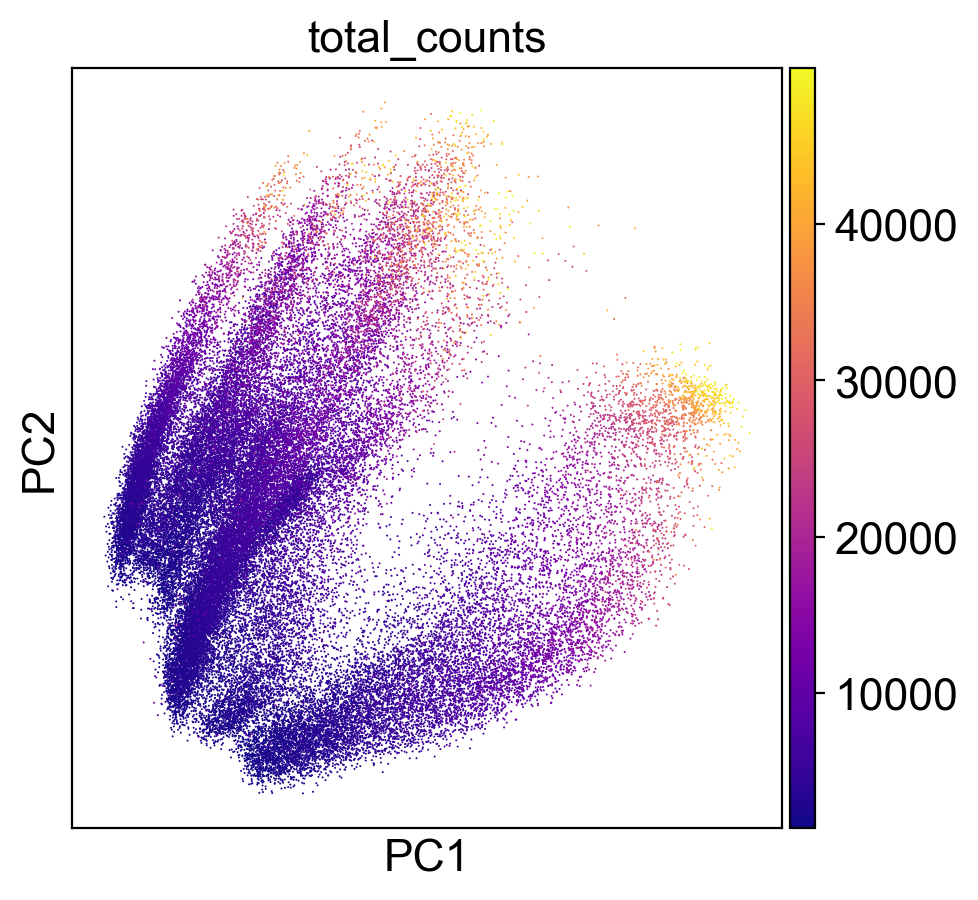

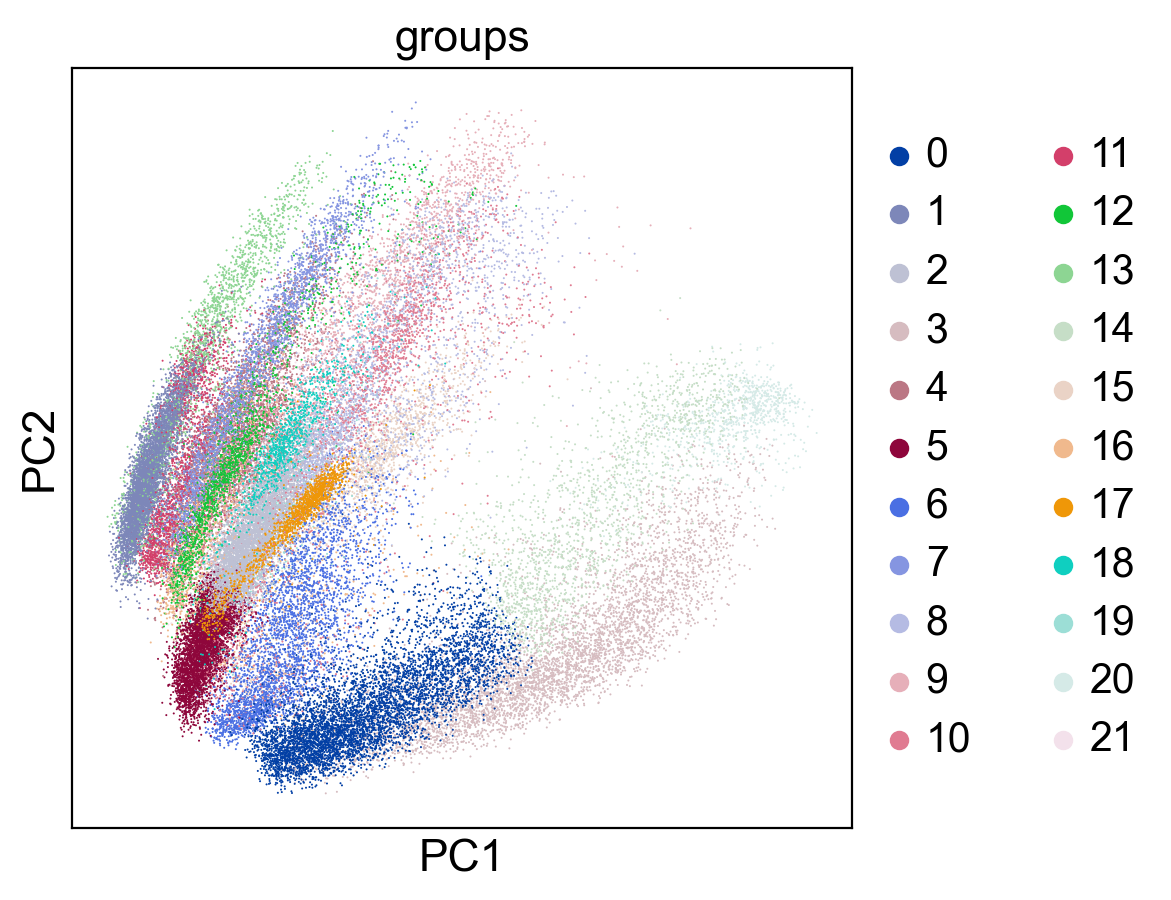

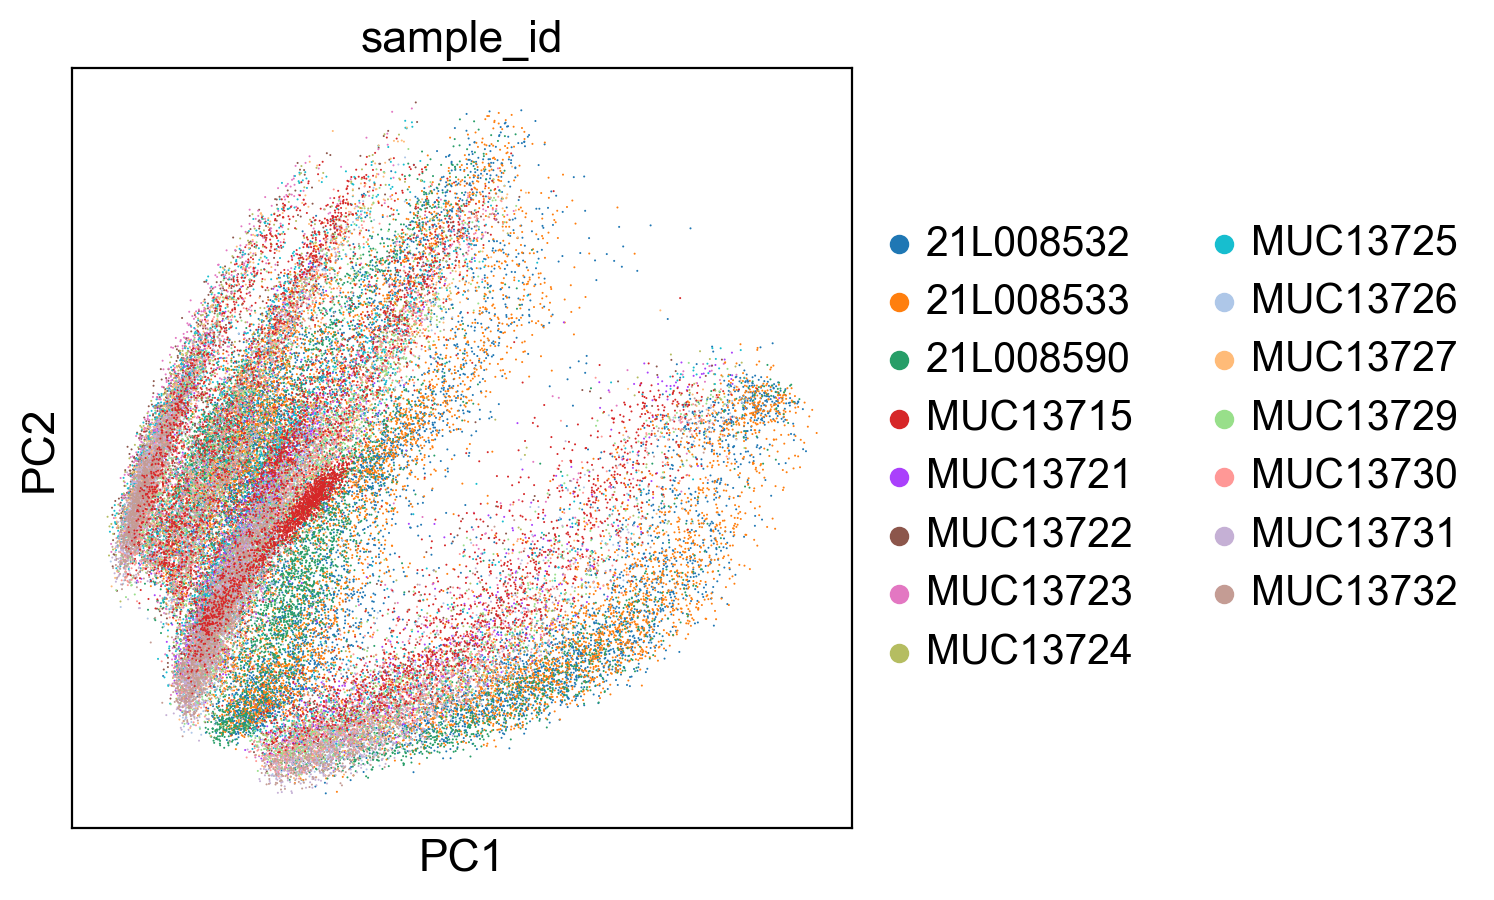

In [63]:
sc.pl.pca(adata_pp,color='total_counts')
sc.pl.pca(adata_pp,color='groups')
sc.pl.pca(adata_pp,color='sample_id')

In [64]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [65]:
%%R -i data_mat -i input_groups -o size_factors
#need to wrap the "computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)" call due to version change in Bioconductor 3.11,
#see issue discussion in: https://github.com/theislab/scib/issues/141
size_factors = BiocGenerics::sizeFactors(
                      scran::computeSumFactors(
                            SingleCellExperiment::SingleCellExperiment(list(
                                  counts=data_mat
                            ))
                          )
                        )


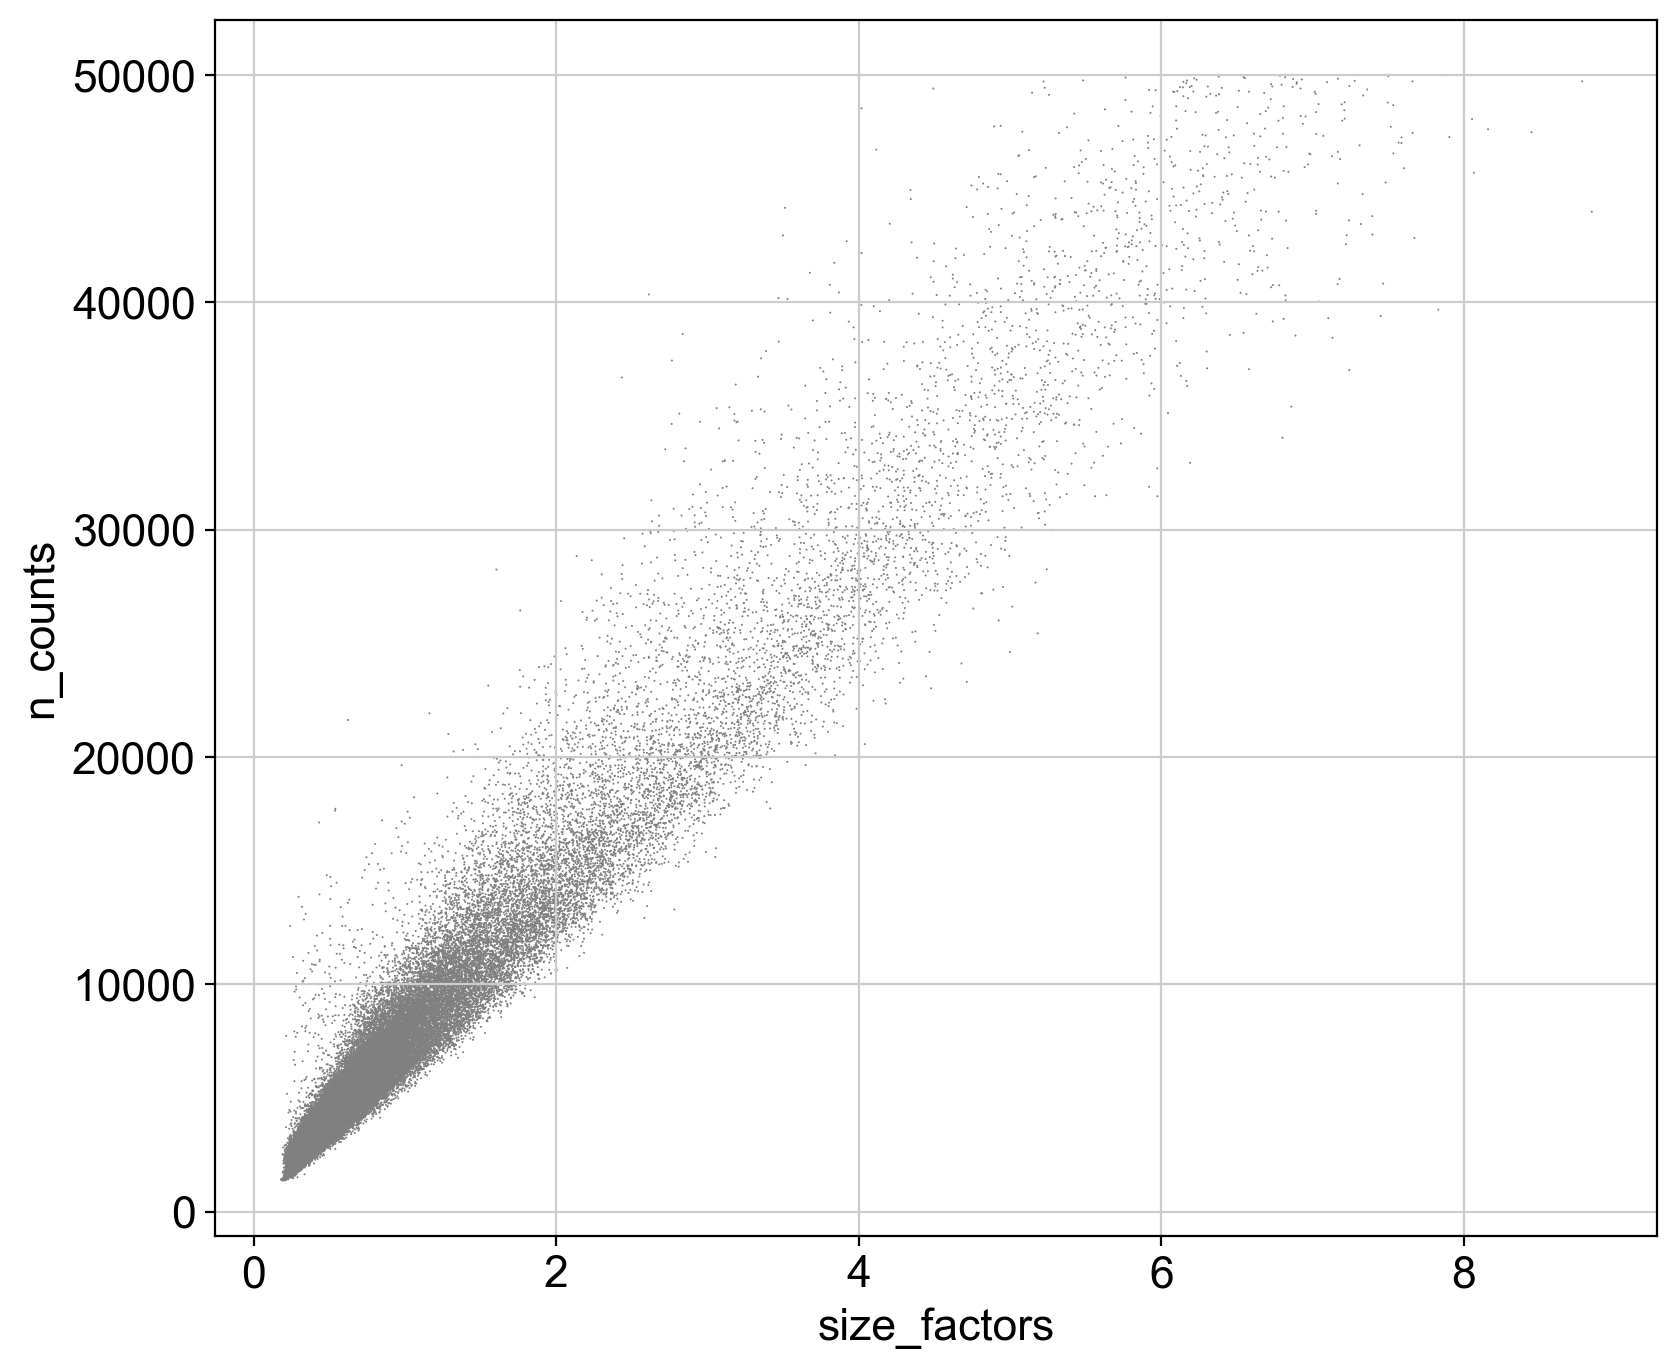

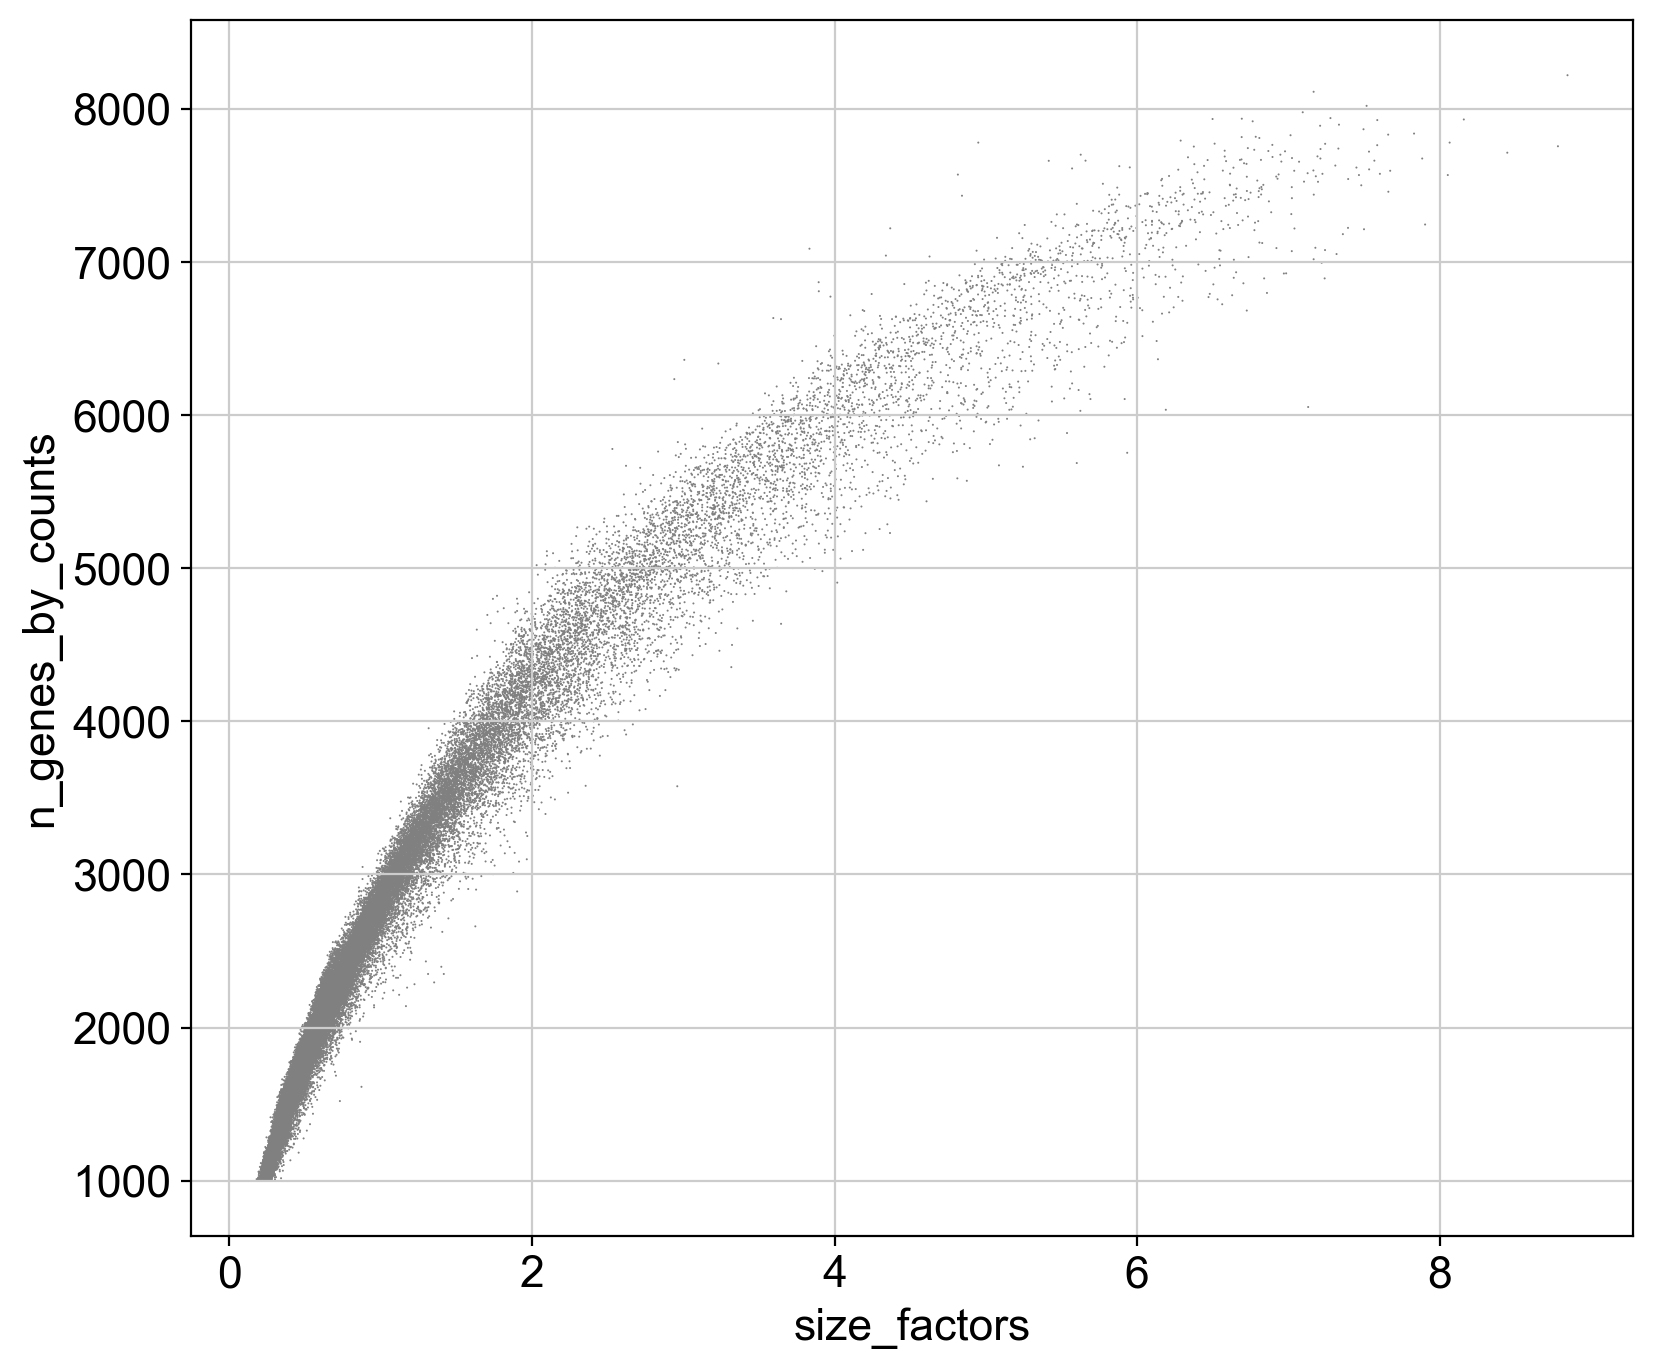

In [66]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes_by_counts')

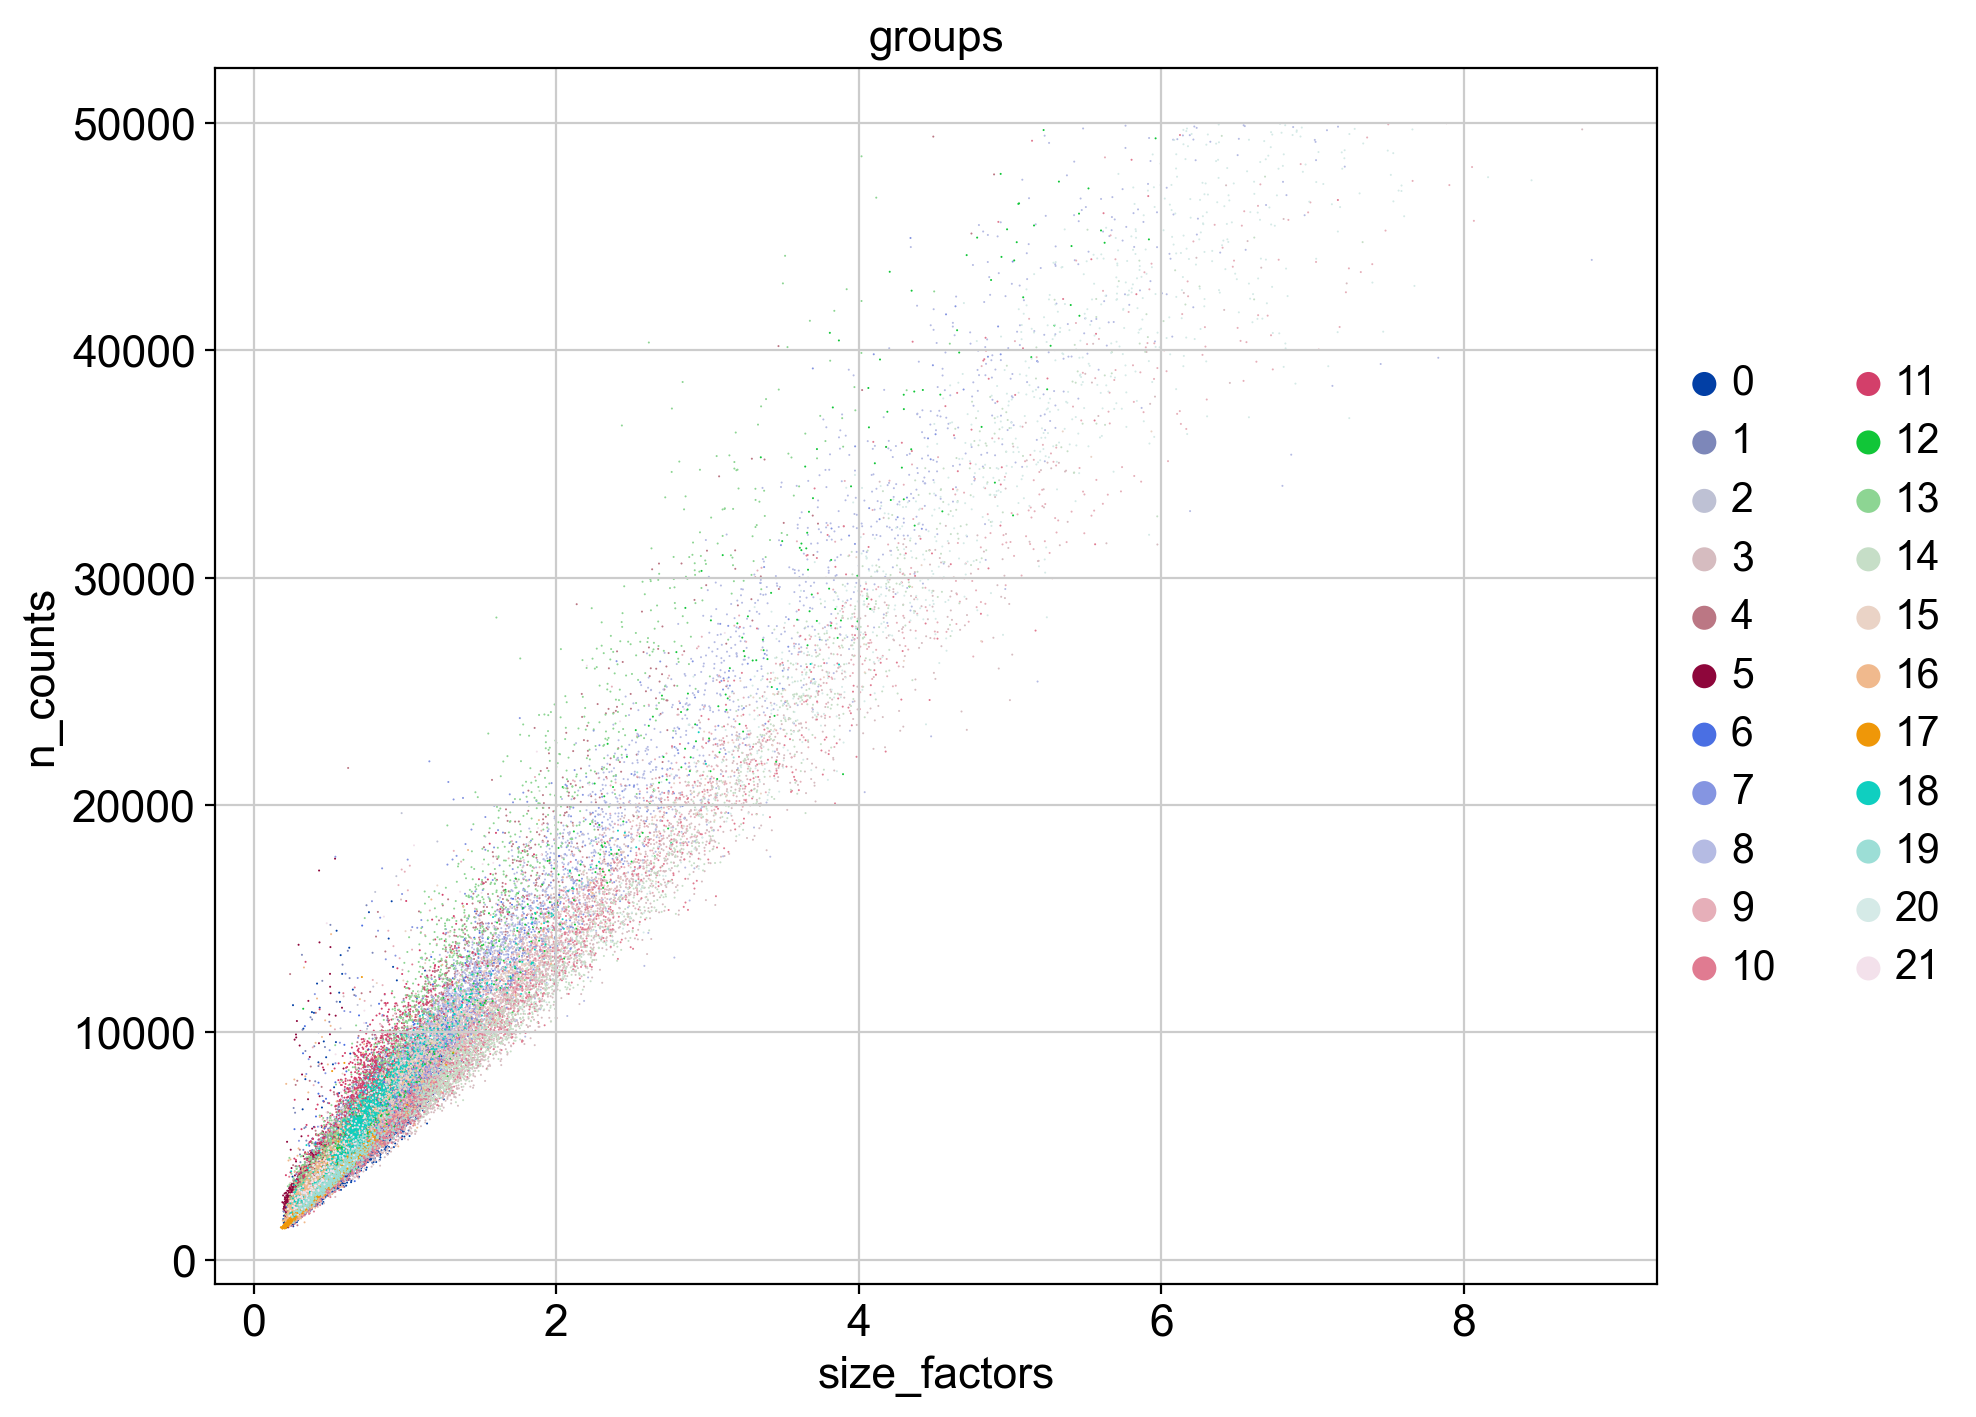

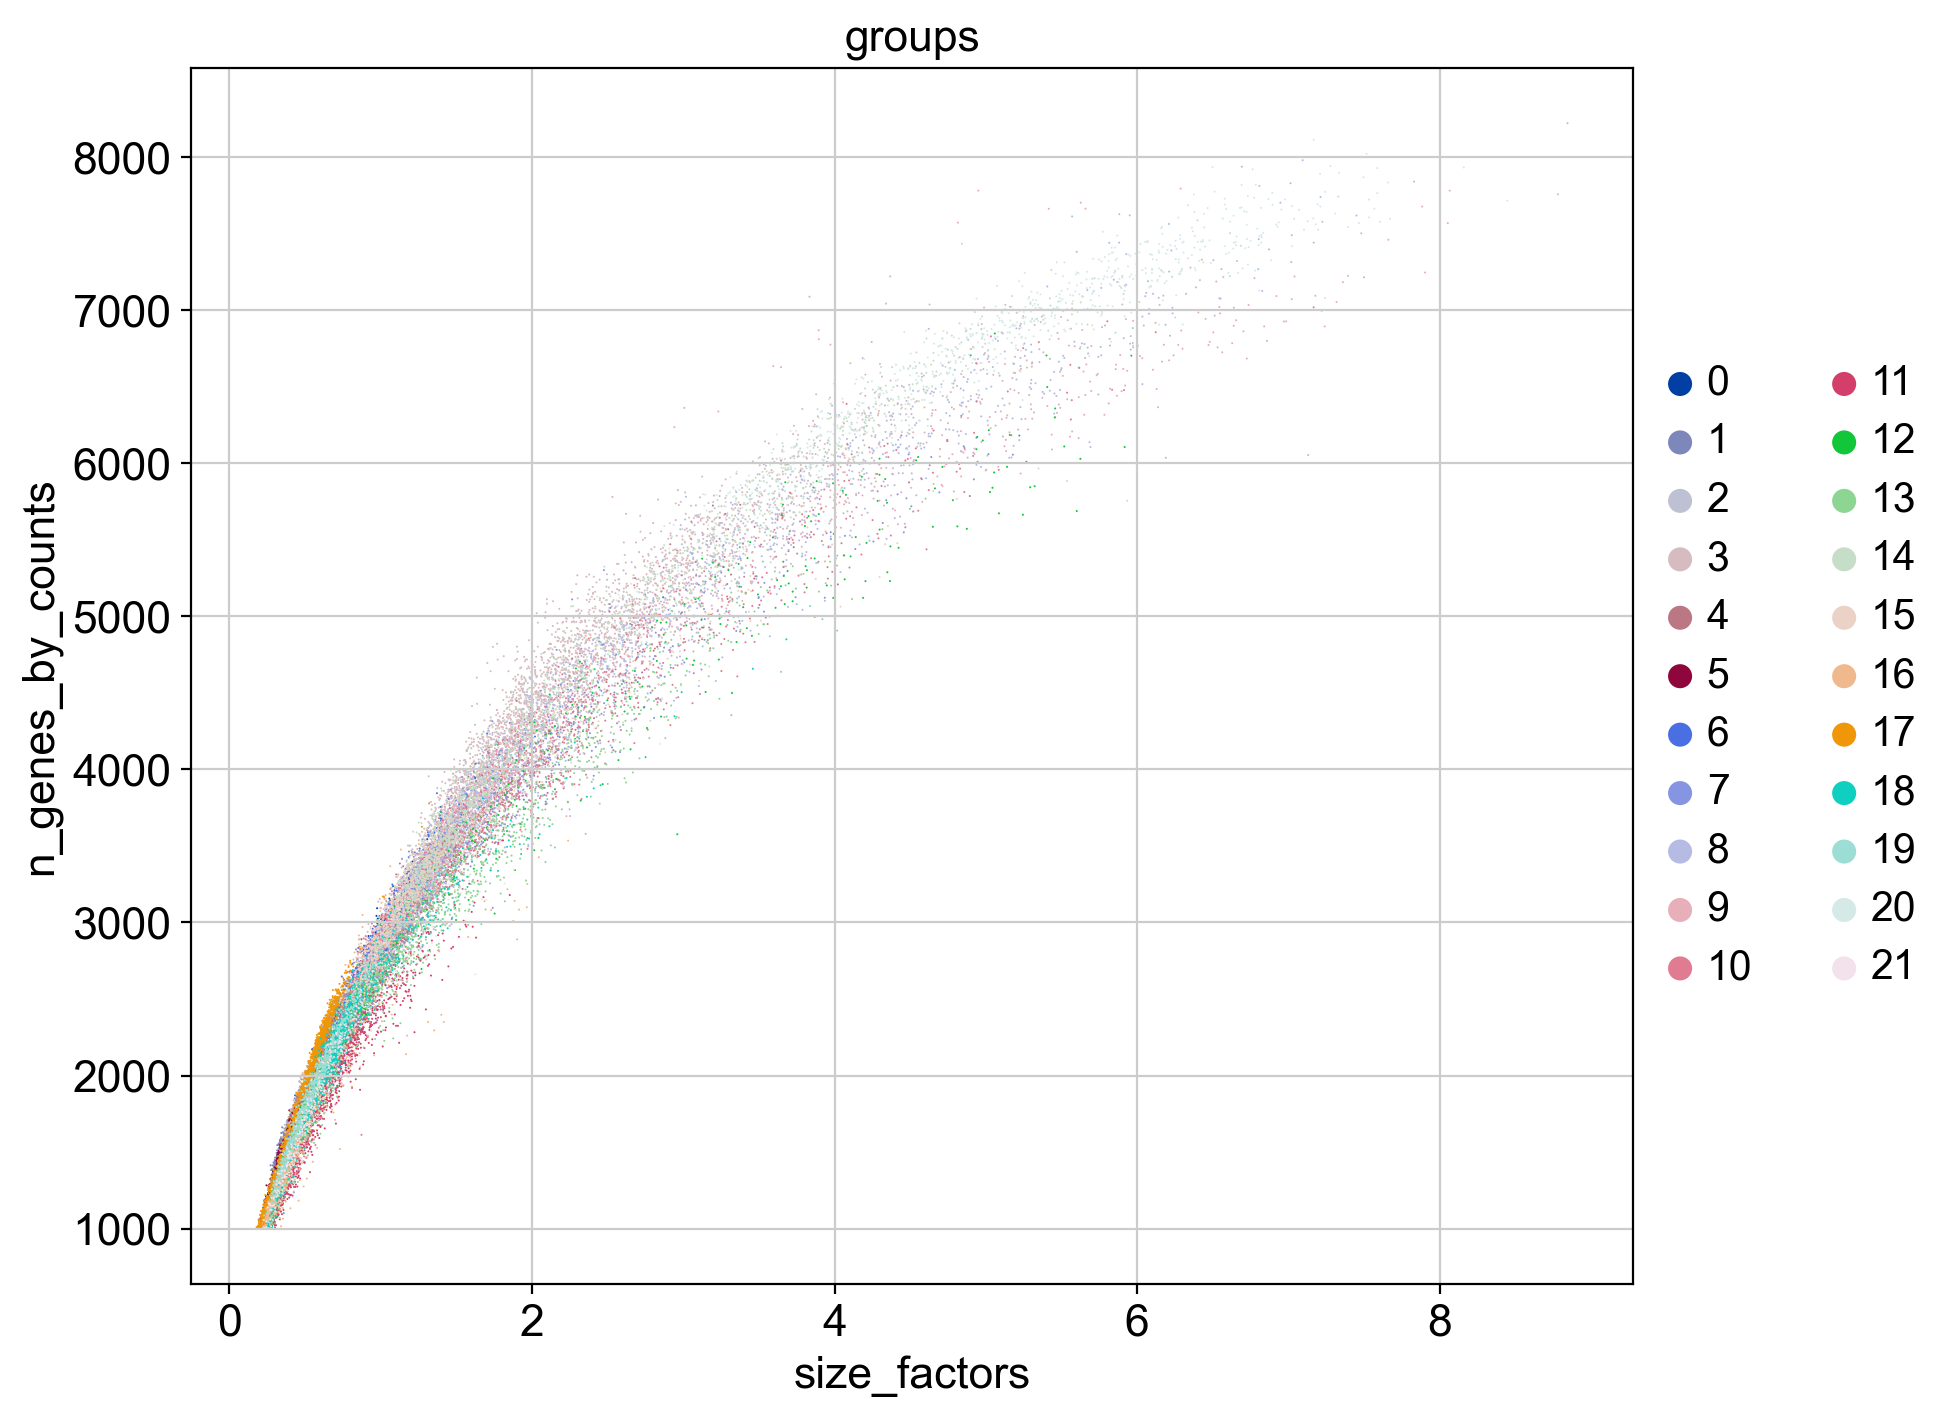

In [67]:
sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes_by_counts', color='groups')

/opt/anaconda3/envs/sc-tutorial-020321/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


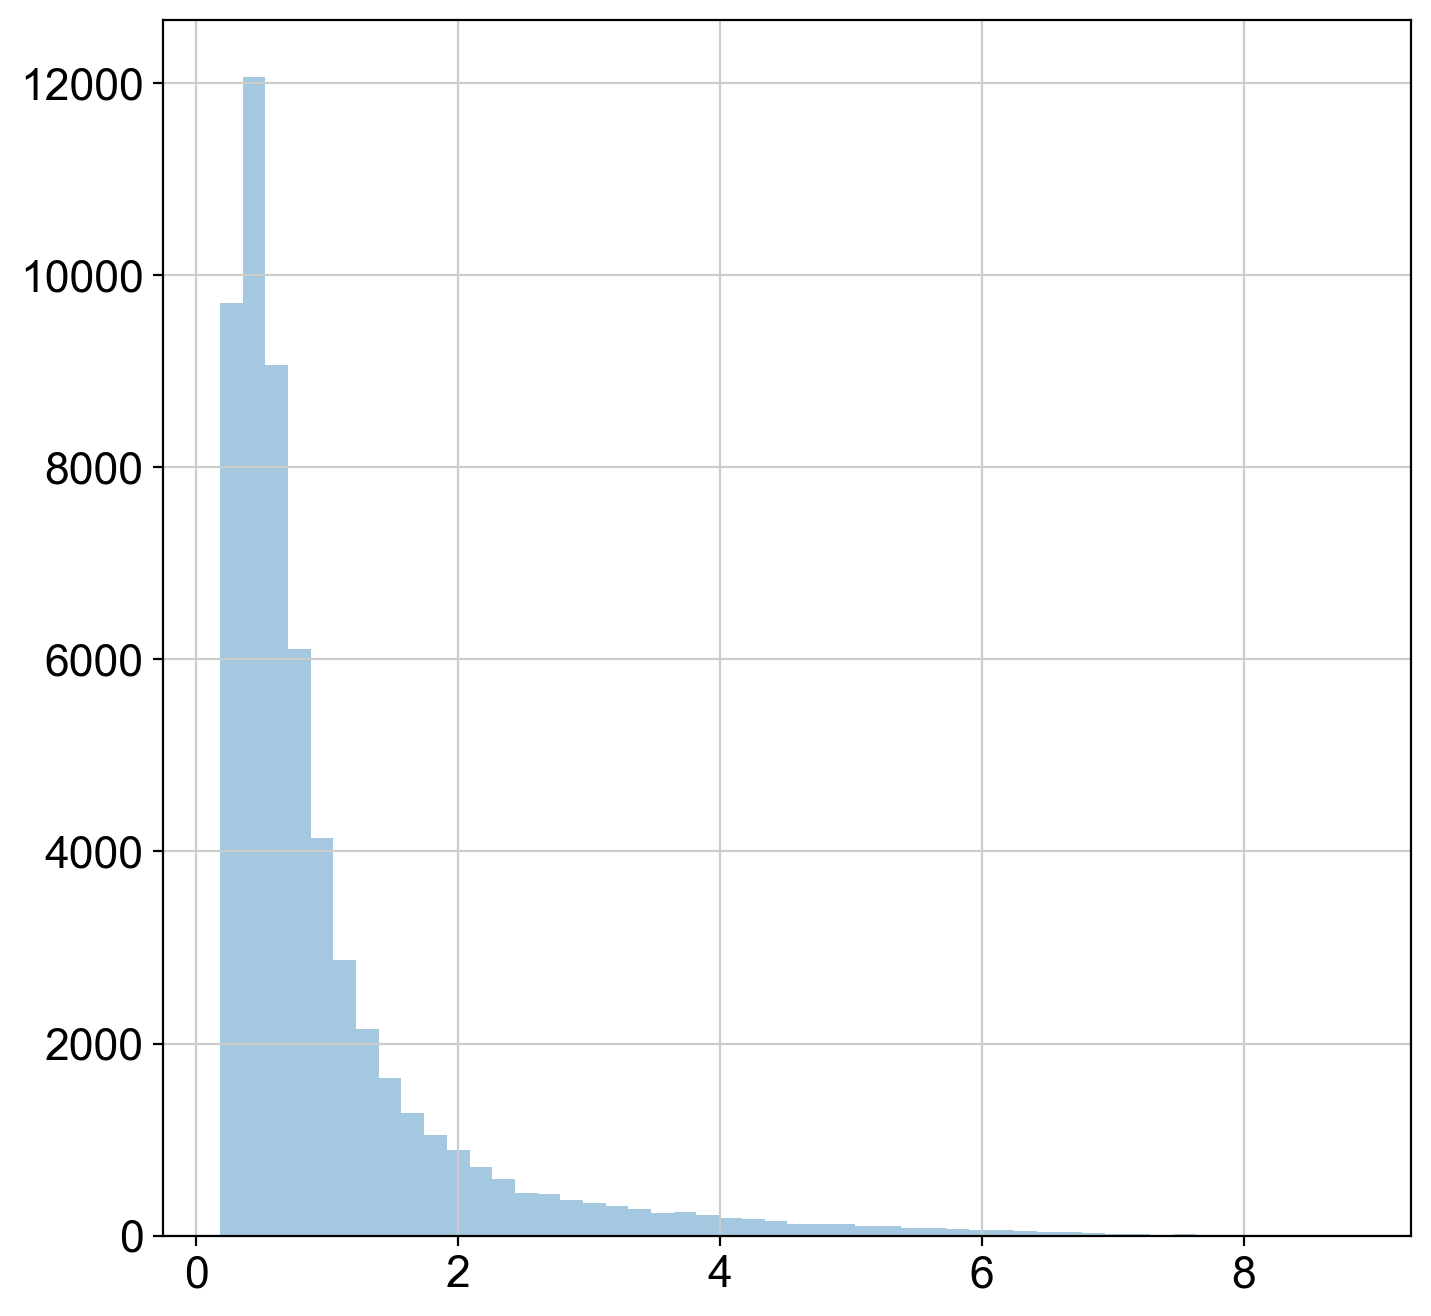

In [68]:
sb.distplot(size_factors, bins=50, kde=False)
plt.show()

Normalize with scran size-factors and log-scale. 

In [69]:
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

Modify the format of the resulting data matrix.

In [70]:
adata.X = np.asarray(adata.X)

Free memory.

In [71]:
del adata_pp

Of note, we convert the gene expression matrix X to the sparse format to memory.

In [72]:
import scipy.sparse as sparse

In [73]:
adata.X = sparse.csr_matrix(adata.X)

In [74]:
adata.raw = adata.copy()

In [75]:
#Keep the count data in a counts layer
adata.layers["counts_lognorm"] = adata.X.copy()

In [76]:
adata

AnnData object with n_obs × n_vars = 56786 × 19290
    obs: 'sample_id', 'sample_id_str', 'condition', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'doublet_score', 'doublet', 'size_factors'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_id_str_colors', 'log1p'
    layers: 'counts', 'counts_lognorm'

In [77]:
#adata.write(data_dir +today+ 'data_postnorm_all_earlytp.h5ad')